# Read and data cleaning

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# from utils.disease_name_mapping import dict_disease_name_mapping
# import utils.disease_name_mapping as dnm
# print(dir(dnm))
### READ DATA ###
df_source = pd.read_csv("data/WWWTable_Epidemics_20250709.csv") # Ë≥áË®äÂÆ§Êèê‰æõ‰πãË≥áÊñô‰æÜÊ∫ê/Êó•ÊúüÊ¨Ñ‰ΩçË≥áÊñô 2019~2025-07-09
df_raw = pd.read_csv('data/TCDCIntlEpidAll.csv')
country_mapping = pd.read_excel('data/03ËºîÂä©Áî®Ë°®_Áõ£Ê∏¨ÂúãÂÆ∂Ê∏ÖÂñÆ.xlsx')
dat_transmission_route_raw = pd.read_excel("data/01Á∏ΩÊï¥_01ÂúãÈöõÁñ´ÊÉÖË≥áÊñôÂ∫´(2017-)_Áõ£Ê∏¨ÁñæÁóÖÊ∏ÖÂñÆ.xlsx")# ÂÇ≥ÊüìÈÄîÂæë
region_mapping = pd.read_excel('data/03ËºîÂä©Áî®Ë°®_Áõ£Ê∏¨ÂúãÂÆ∂Ê∏ÖÂñÆ.xlsx', sheet_name="Áõ£Ê∏¨ÂúãÂÆ∂&ÂçÄÂüüÊ∏ÖÂñÆ")


### DATA CLEANING ###

df_raw["date"] = pd.to_datetime(df_raw['effective'], errors='coerce').dt.date

research_end_date = pd.to_datetime('2025-07-09').date()
df_raw = df_raw[df_raw['date'] <= research_end_date]


df_raw[['headline_country', 'headline_disease']] = df_raw['headline'].str.split(r'[-Ôºç‚îÄ]', n=1, expand=True) 
    # either half-width - or full-width Ôºç or Box-drawing dash ‚îÄ
df_raw['headline_country'] = df_raw['headline_country'].str.strip()
df_raw['headline_disease'] = df_raw['headline_disease'].str.strip()



df_source = df_source[["Subject","Source","SourceTime","SourceTime2","PublishTime"]]
df_source['SourceTime'] = pd.to_datetime(df_source['SourceTime'], errors='coerce').dt.date #Ë≥áÊñô‰æÜÊ∫êÊó•Êúü(Ëµ∑)
df_source['SourceTime2'] = pd.to_datetime(df_source['SourceTime2'], errors='coerce').dt.date #Ë≥áÊñô‰æÜÊ∫êÊó•Êúü(ËøÑ)
df_source['PublishTime'] = pd.to_datetime(df_source['PublishTime'], errors='coerce').dt.date
# print(df_source.head(2))

# Merge df_source into df_raw
df_raw = df_raw.merge(df_source, how="left", left_on=["date","headline"], right_on=["PublishTime","Subject"])

# drop useless columns
df_raw = df_raw.drop(
    ["sent", "effective", "source", "expires", "senderName", "instruction", "alert_title", "severity_level", "circle", "headline"], axis=1)#web


#print(df_raw.head(2))


# some date are filled in descriptions or source, requiring efforts to extract them through
view_missing_source_time = df_raw[df_raw['SourceTime'].isna()]
view_missing_source_time['year'] = pd.to_datetime(view_missing_source_time['date']).dt.year
yearly_counts = view_missing_source_time.groupby('year').size().reset_index(name='row_count')
# print(yearly_counts)
# view_missing_source_time.to_csv("missing date.csv")

#disease name frequency
# table_disease_freq = df_raw['headline_disease'].value_counts()
# # print(table_disease_freq.head(5))

# table_alert_disease_freq = df_raw['alert_disease'].value_counts() # alert disease is the original cell for the disease names which require lawful reporting
# # print(table_alert_disease_freq.head(5))



C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_12716\3718384467.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Country names mapping

In [194]:
#####
# (1) Build a mapping using 03ËºîÂä©Áî®Ë°®_Áõ£Ê∏¨ÂúãÂÆ∂Ê∏ÖÂñÆ.xlsx: each variation matches one ISO3
#####
variation_to_iso3 = {}

for idx, row in country_mapping.iterrows():
    iso3 = row['ISO3166-1‰∏â‰Ωç‰ª£Á¢º']
    if pd.isna(iso3):
        continue  # skip entries without ISO3

    variations = set() # Collect variations from different columns

    if pd.notna(row['Áõ£Ê∏¨ÂúãÂÆ∂/ÂçÄÂüü']):
        variations.add(str(row['Áõ£Ê∏¨ÂúãÂÆ∂/ÂçÄÂüü']).strip())
    if 'ISO3166-1(‰∏≠Êñá)' in row and pd.notna(row['ISO3166-1(‰∏≠Êñá)']):
        variations.add(str(row['ISO3166-1(‰∏≠Êñá)']).strip())
    if 'Â§ñÁ∂≤ÂúãÂÆ∂Âà•' in row and pd.notna(row['Â§ñÁ∂≤ÂúãÂÆ∂Âà•']):
        variations.add(str(row['Â§ñÁ∂≤ÂúãÂÆ∂Âà•']).strip())
    if '‰∏≠ÊñáÂà•Á®±' in row and pd.notna(row['‰∏≠ÊñáÂà•Á®±']):
        aliases = str(row['‰∏≠ÊñáÂà•Á®±']).split('|') # split by '|'
        variations.update([alias.strip() for alias in aliases])

    for var in variations:
        variation_to_iso3[var] = iso3

print(list(variation_to_iso3.items())[:20]) # items is dictionary method that returns a view object containing key-value pairs as tuples.

# Sort mapping by length of variation (descending): Longest variations are checked first, which can prevent confusion such as È¶¨Âà© in Á¥¢È¶¨Âà©‰∫û
sorted_mapping = sorted(
    variation_to_iso3.items(),  # your dictionary of variation ‚ûî ISO3
    key=lambda x: len(x[0]),    # sort by length of variation string
    reverse=True                # longest first
)

# After extracting a matched variation, remove it from the text to "avoid re-matching shorter substrings" within it.
def extract_country_iso3_from_description(text, sorted_mapping):
    found_iso3 = set()  #Automatically remove duplicates if the same country is mentioned multiple times.
    if not isinstance(text, str):
        return None
    
    text_remaining = text
    for var, iso3 in sorted_mapping:
        if var in text_remaining:
            found_iso3.add(iso3)
            text_remaining = text_remaining.replace(var, '')# !  # Remove the matched variation from text_remaining to prevent further substring matches

    return list(found_iso3) if found_iso3 else None

# After extracting a matched variation, remove it from the text to "avoid re-matching shorter substrings" within it.
def extract_country_iso3_from_description(text, sorted_mapping):
    found_iso3 = set()#Automatically remove duplicates if the same country is mentioned multiple times.
    if not isinstance(text, str):
        return None

    text_remaining = text

    # Regex pattern to detect "CountryA ÂÖ¨Â∏É CountryB", where the exclusion condition applies (Country A ‚â† Country B)
    pattern_pub = re.compile(r'(\S+?)ÂÖ¨Â∏É(\S+)')
    match = pattern_pub.search(text_remaining)

    excluded_country = None
    included_country = None
    if match:
        excluded_country = match.group(1).strip() 
        included_country = match.group(2).strip() 

    for var, iso3 in sorted_mapping:
        if var in text_remaining:
            if excluded_country and included_country and var == excluded_country and var != included_country:
                continue 

            found_iso3.add(iso3)
            text_remaining = text_remaining.replace(var, '')#!Remove the matched variation from text_remaining to prevent further substring matches

    return list(found_iso3) if found_iso3 else None

df_raw['description_iso3'] = df_raw['description'].apply(
    lambda x: extract_country_iso3_from_description(x, sorted_mapping))



#####
# (2) Screening the two-value code from ISO3166 to avoid loss of extration
#####

# transform iso2 to iso3
iso2_to_iso3 = {}
for idx, row in country_mapping.iterrows():
    iso2 = row['ISO3166-1‰∫å‰Ωç‰ª£Á¢º']
    iso3 = row['ISO3166-1‰∏â‰Ωç‰ª£Á¢º']
    if pd.notna(iso2) and pd.notna(iso3):
        iso2_to_iso3[str(iso2).strip()] = str(iso3).strip()

def convert_iso2_to_iso3(iso2_str, mapping_dict):
    if pd.isna(iso2_str):
        return None
    
    iso2_str = str(iso2_str).strip()
    
    iso2_list = [code.strip() for code in iso2_str.split(',')]# Split if multiple codes
    
    iso3_list = [mapping_dict.get(code) for code in iso2_list if mapping_dict.get(code)]
    
    return iso3_list if iso3_list else None

df_raw['ISO3166_to_3code'] = df_raw['ISO3166'].apply(lambda x: convert_iso2_to_iso3(x, iso2_to_iso3))

###
# (3) screening country names from headline
### 
headline_cn_to_iso3 = {}

for idx, row in country_mapping.iterrows():
    iso3 = row['ISO3166-1‰∏â‰Ωç‰ª£Á¢º']
    if pd.isna(iso3):
        continue
    # ÂÖ®ÁêÉ/ÁæéÊ¥≤/Ê≠êÊ¥≤ will be None due to lack of iso3 code
    if pd.notna(row['‰∏≠ÊñáÂà•Á®±']):
        aliases = [alias.strip() for alias in str(row['‰∏≠ÊñáÂà•Á®±']).split('|')]
        for alias in aliases:
            headline_cn_to_iso3[alias] = iso3

def map_headline_country_to_iso3(headline_country_str, mapping_dict):
    if pd.isna(headline_country_str):
        return None
    countries = [c.strip() for c in str(headline_country_str).split('/')] #Splits the string by / to get individual countries.
    iso3_list = [mapping_dict.get(c) for c in countries if mapping_dict.get(c)]
    return iso3_list if iso3_list else None

df_raw['headline_country_iso3'] = df_raw['headline_country'].apply(
    lambda x: map_headline_country_to_iso3(x, headline_cn_to_iso3) )

###
# (4) create consolidated country_iso3 by set (description_iso3 and ISO3166_to_3code and headline_country_iso3 )
###
def combine_iso_codes(iso2_3code, description, headline):
    combined_set = set()    
    if isinstance(iso2_3code, list):
        combined_set.update(iso2_3code)
    elif pd.notna(iso2_3code): 
        combined_set.add(iso2_3code)
    
    if isinstance(description, list):
        combined_set.update(description)
    
    if isinstance(headline, list):
        combined_set.update(headline)
    
    return list(combined_set) if combined_set else None

df_raw['country_iso3'] = df_raw.apply(
    lambda row: combine_iso_codes(row['ISO3166_to_3code'], 
                                  row['description_iso3'],
                                  row['headline_country_iso3']),
    axis=1
)

print(df_raw[['ISO3166','ISO3166_to_3code', 'description_iso3', 'headline_country_iso3','country_iso3']].head(10))


[('ÂçóÊ•µÊ¥≤', 'ATA'), ('ÈòøÂØåÊ±ó', 'AFG'), ('ÈòøÁàæÂ∑¥Â∞º‰∫û', 'ALB'), ('ÈòøÁàæÂèäÂà©‰∫û', 'DZA'), ('ÁæéÂ±¨Ëñ©Êë©‰∫û', 'ASM'), ('ÁæéÂ±¨Ëñ©Êë©‰∫û(ÁæéÂ±¨)', 'ASM'), ('ÂÆâÈÅìÁàæ', 'AND'), ('ÂÆâÂì•Êãâ', 'AGO'), ('ÂÆâÂêâÊãâ(Ëã±Â±¨)', 'AIA'), ('ÂÆâÂêâÊãâ(Ëã±ÂúãÊµ∑Â§ñÈ†òÂú∞)', 'AIA'), ('ÂÆâÂêâÊãâ', 'AIA'), ('ÂÆâÂú∞Âç°ÂèäÂ∑¥Â∏ÉÈÅî', 'ATG'), ('ÈòøÊ†πÂª∑', 'ARG'), ('‰∫ûÁæéÂ∞º‰∫û', 'ARM'), ('ÈòøÈ≠ØÂ∑¥', 'ABW'), ('Ëç∑Â±¨ÈòøÈ≠ØÂ∑¥', 'ABW'), ('ÈòøÈ≠ØÂ∑¥(Ëç∑Â±¨)', 'ABW'), ('Êæ≥Ê¥≤', 'AUS'), ('Êæ≥Â§ßÂà©‰∫û', 'AUS'), ('Â•ßÂú∞Âà©', 'AUT')]
    ISO3166 ISO3166_to_3code  \
0  AU,IN,ZA  [AUS, IND, ZAF]   
1        BT            [BTN]   
2     CD,TJ       [COD, TJK]   
3        FR            [FRA]   
4     HN,ML       [HND, MLI]   
5     MG,MM       [MDG, MMR]   
6        IN            [IND]   
7        KH            [KHM]   
8       NaN             None   
9       NaN             None   

                                    description_iso3 headline_country_iso3  \
0                                    [Z

In [195]:
# Checks for substring confusion only between different ISO3 codes,

# confusion_list = []

# # Build a list of all variations with their ISO3 code
# variation_iso3_pairs = []

# for idx, row in country_mapping.iterrows():
#     iso3 = row['ISO3166-1‰∏â‰Ωç‰ª£Á¢º']
#     if pd.isna(iso3):
#         continue

#     # Process ‰∏≠ÊñáÂà•Á®± column
#     if pd.notna(row['‰∏≠ÊñáÂà•Á®±']):
#         aliases = [alias.strip() for alias in str(row['‰∏≠ÊñáÂà•Á®±']).split('|')]
#         for alias in aliases:
#             variation_iso3_pairs.append( (alias, iso3) )

# # Check for substring confusion among ‰∏≠ÊñáÂà•Á®± variations across different ISO3 codes
# for i, (var1, iso3_1) in enumerate(variation_iso3_pairs):
#     for j, (var2, iso3_2) in enumerate(variation_iso3_pairs):
#         if (
#             i != j 
#             and iso3_1 != iso3_2  # Only between different ISO3 codes
#             and var1 in var2
#         ):
#             confusion_list.append( (var1, var2, iso3_1, iso3_2) )

# # Display potential confusion pairs
# for c in confusion_list:
#     print(f"Alias '{c[0]}' (ISO3: {c[2]}) is substring of '{c[1]}' (ISO3: {c[3]})")


In [196]:
# assess difference 
df_diff = df_raw[
    df_raw.apply(
        lambda row: set(row['ISO3166_to_3code'] or []) != set(row['description_iso3'] or []),
        axis=1
    )
]

# Display result
print(df_diff[['description','ISO3166_to_3code', 'description_iso3', 'country_iso3']].head(10))

# there is all NA
# df_na = df_diff[df_diff['country_iso3'].isna()]
# print(df_na[['description', 'ISO3166_to_3code', 'description_iso3', 'country_iso3']].head(10))


                                          description  \
7      Êú¨ÈÄ±ÊëòË¶ÅÔºö  \r‰∫∫È°ûÁñ´ÊÉÖÔºöÊü¨ÂüîÂØ®Êñ∞Â¢û4‰æãH5N1ÊµÅÊÑü‰∫∫È°ûÊÑüÊüìÁóÖ‰æã„ÄÇ  Á¶Ω/ÂãïÁâ©Áñ´ÊÉÖ(...   
8   Áñ´ÊÉÖÊõ¥Êñ∞Ôºö  \r2025Âπ¥Á¨¨24ÈÄ±(6/9-15)ÂÖ®ÁêÉÈôΩÊÄßÁéá4.02%ÔºåÁæéÊ¥≤„ÄÅÊ≠êÊ¥≤„ÄÅÊù±Âú∞‰∏≠...   
9   Áñ´ÊÉÖÊõ¥Êñ∞Ôºö  \r2025Âπ¥Á¨¨24ÈÄ±(6/9-15)ÂÖ®ÁêÉÈôΩÊÄßÁéá4.02%ÔºåÁæéÊ¥≤„ÄÅÊ≠êÊ¥≤„ÄÅÊù±Âú∞‰∏≠...   
10  ÂÖ®ÁêÉÂ∞èÂÖíÈ∫ªÁó∫Ê†πÈô§ÂÄ°Ë≠∞ÁµÑÁπî(GPEI)ÂÖ¨Â∏ÉÊñº6/19-25ÊúüÈñìÔºåWPV1Êñ∞Â¢ûÂ∑¥Âü∫ÊñØÂù¶1‰æãÔºåcV...   
35  Êú¨ÊúàÊõ¥Êñ∞Ôºö  \rÂÖ®ÁêÉËá™2022Âπ¥6ÊúàÊà™Ëá≥‰ªäÂπ¥6/26Á¥ØË®à138Âúã/Âú∞ÂçÄÂ†±Âëä15Ëê¨195‰æãÁ¢∫...   
36  Êú¨ÈÄ±ÊëòË¶ÅÔºö  \r‰∫∫È°ûÁñ´ÊÉÖÔºöÊü¨ÂüîÂØ®Êñ∞Â¢û2‰æãH5N1ÊµÅÊÑü‰∫∫È°ûÊÑüÊüìÁóÖ‰æã„ÄÇ \rÁ¶Ω/ÂãïÁâ©Áñ´ÊÉÖ(WA...   
38  ÂÖ®ÁêÉÂ∞èÂÖíÈ∫ªÁó∫Ê†πÈô§ÂÄ°Ë≠∞ÁµÑÁπî(GPEI)ÂÖ¨Â∏ÉÊñº6/12-18ÊúüÈñìÔºåcVDPV2Êñ∞Â¢û2ÂúãÂÖ±5‰æãÔºåÂàÜ...   
42       Âç∞ÂÖ±4ÁúÅÂ†±Âëä8‰æãÔºåÂàÜÂà•ÂàÜÂà•‰æÜËá™Êó•ÊÉπ/Ë•øÁà™Âìá/Êù±Âä™Ê≤ôÁôªÂä†Êãâ/ÂåóËòáÊãâÂ®ÅË•øÔºåÊâÄÊúâÁóÖÊÇ£ÂùáÂ∑≤Â∫∑Âæ©„ÄÇ   
43       Âç∞ÂÖ±4ÁúÅÂ†±Âëä8‰æãÔºåÂàÜÂà•ÂàÜÂà•‰æÜ

### Disease name mapping

In [197]:
## Disease Name Mapping: for main name, sub name
# def clean_heading_disease_name(name):
#     name = re.sub(r'\(.*?\)', '', name)     # ÁßªÈô§Êã¨ËôüÂÖßÁöÑÂÖßÂÆπ
#     name = re.sub(r'^\d+', '', name)    # ÂéªÈô§Êï∏Â≠óÈñãÈ†≠
#     return name.strip()

# df_raw['headline_disease'] = df_raw['headline_disease'].apply(clean_heading_disease_name)

# import sys
# sys.path.append('/utils/disease_name_mapping')

# import my_script

# %run  01_disease_name_mapping.py


dict_disease_name_mapping = { #multiple diseases are splitted by /
    'Êñ∞ÂûãÂÜ†ÁãÄÁóÖÊØíËÇ∫ÁÇé': 'COVID-19',  #old name: new name
    'Âö¥ÈáçÁâπÊÆäÂÇ≥ÊüìÊÄßËÇ∫ÁÇé': 'COVID-19',
    "Êñ∞ÂûãÂÜ†ÁãÄËÇ∫ÁÇé": "COVID-19", # n=1
    #"Êñ∞ÂûãÂÜ†ÁãÄÁóÖÊØí": "COVID-19", This is MERS
    "Êñ∞ÂÜ†‰ΩµÁôºÈáçÁóá(ÊØèÈÄ±Êõ¥Êñ∞)": 'COVID-19',
    "Êñ∞ÂÜ†‰ΩµÁôºÈáçÁóá(Êú¨ÈÄ±Êõ¥Êñ∞)": "COVID-19", 
    'Êñ∞ÂÜ†‰ΩµÁôºÈáçÁóá': 'COVID-19',
    "‰∏≠Êù±ÂëºÂê∏ÁóáÂÄôÂÜ†ÁãÄÁóÖÊØí":"‰∏≠Êù±ÂëºÂê∏ÁóáÂÄôÁæ§ÂÜ†ÁãÄÁóÖÊØíÊÑüÊüìÁóá",
    "‰∏≠Êù±ÂëºÂê∏ÁóáÂÄôÁæ§ÂÜ†ÁãÄÂÆöÊØí":"‰∏≠Êù±ÂëºÂê∏ÁóáÂÄôÁæ§ÂÜ†ÁãÄÁóÖÊØíÊÑüÊüìÁóá",
    "‰∏≠Êù±ÂëºÂê∏ÁóáÂÄôÁæ§ÁãÄÁóÖÊØí":"‰∏≠Êù±ÂëºÂê∏ÁóáÂÄôÁæ§ÂÜ†ÁãÄÁóÖÊØíÊÑüÊüìÁóá",
    "Áå¥Áóò": "MÁóò",
    "MÁóò(ÊØèÊúàÊõ¥Êñ∞)": "MÁóò",
    "MÁóò(ÊØèÈÄ±Êõ¥Êñ∞)": "MÁóò",
    "MÁóò(Êú¨ÈÄ±Êõ¥Êñ∞)": "MÁóò",
    "Êñ∞ÂûãAÂûãÊµÅÊÑü(ÊØèÈÄ±Êõ¥Êñ∞)": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    'Êñ∞ÂûãAÂûãÊµÅÊÑü(Êú¨ÈÄ±Êõ¥Êñ∞)': "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    'Êñ∞ÂûãAÂûãÊµÅÊÑü(H3N2v)': "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    'Êñ∞ÂûãAÂûãÊµÅÊÑü(H9N2)' : "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "Êñ∞ÂûãAÂûãÊµÅÊÑü(H9N2/H10N3)": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "Êñ∞ÂûãAÂûãÊµÅÊÑü(H5N1)": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    #"Êñ∞ÂûãAÂûãÊµÅÊÑü(Âì∫‰π≥ÂãïÁâ©ÊÑüÊüìÁ¶ΩÊµÅÊÑü)": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "Êñ∞ÂûãAÂûãÊµÅÊÑü(H5)": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "‰∫∫È°ûH5N1ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    'H7N9ÊµÅÊÑü': 'Êñ∞ÂûãAÂûãÊµÅÊÑü',
    "H5N1ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H3N8ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H3N1vÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H3N2vÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H5ÊµÅÊÑü":  "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N2vÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H5N6ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H9N2ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H3N1vÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N2vÊµÅÊÑüÁóÖ‰æã": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1vÊµÅÊÑü":  "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    'H3N2vÊµÅÊÑü': "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    'H3N2v„ÄÅH1N2vÊµÅÊÑü': "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N1vÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N2ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H5N8ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H10N3ÊµÅÊÑü" : "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N1ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N1Êñ∞ÂûãÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "‚îÄH7N9ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H10N8ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N1v ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N1Êñ∞ÂûãÊµÅÊÑü  ( Âä†Â∑û Âæ∑Â∑û )": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N1Êñ∞ÂûãÊµÅÊÑü ( Âä†Â∑û Âæ∑Â∑û Â†™Ëñ©ÊñØÂ∑û Á¥êÁ¥Ñ ‰øÑ‰∫•‰øÑÂ∑û)": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N1Êñ∞ÂûãÊµÅÊÑü ( Âä†Â∑û Âæ∑Â∑û Â†™Ëñ©ÊñØÂ∑û)": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N1Êñ∞ÂûãÔßäÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N1Ë±¨ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H1N2ËÆäÁï∞Ê†™": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H2N2ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H3N1ÁóÖÊØí": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H3N2VÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H3N2v„ÄÅH3vÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H3N2Ë±¨ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H3ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H3Ë±¨ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H5N1„ÄÅH9N2ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H5N1Áñ´Ëãó": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H5N2È´òÁóÖÂéüÊÄßÁ¶ΩÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H5N6„ÄÅH7N9ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H7N2ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H7N4ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H7N7ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H7N9": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H7N9„ÄÅH5N6ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H7ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H7Á¶ΩÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "H9ÊµÅÊÑü": "Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "Êñ∞ÂûãAÂûãÊµÅÊÑü(Âì∫‰π≥ÂãïÁâ©ÊÑüÊüìÁ¶ΩÊµÅÊÑü)":"Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "Êñ∞ÂûãAÂûãÊµÅÊÑü(Áñ´Ëãó)":"Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "Êñ∞ÂûãAÊµÅÊÑü":"Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "‰∫∫È°ûH5N1ÊµÅÊÑü" :"Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "‰∫∫È°ûÁ¶ΩÊµÅÊÑü":"Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "Êñ∞ÂûãÔº°ÂûãÊµÅÊÑü(Âì∫‰π≥ÂãïÁâ©ÊÑüÊüìÁ¶ΩÊµÅÊÑü)":"Êñ∞ÂûãÔº°ÂûãÊµÅÊÑü",
    "ÊµÅÊÑü„ÄÅÊñ∞ÂûãAÂûãÊµÅÊÑü":"ÊµÅÊÑü/Êñ∞ÂûãAÂûãÊµÅÊÑü",
    "Echovirus 30 (E30)": "ËÖ∏ÁóÖÊØí",
    '1ËÖ∏ÈÅìËèåÊÑüÊüìÁóá': 'ËÖ∏ÈÅìËèåÊÑüÊüìÁóá',
    # "ÁóÖÊØíÊÄßËÖ∏ËÉÉÁÇé(Ë´æÁæÖÁóÖÊØí)": "",
    "ÁóÖÊØíÊÄßËÖ∏ËÉÉÁÇé(Ê≤ôÈñÄÊ∞èËèå)": "Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá",
    "Ê≤ôÈñÄÊ∞èËèåÁóá":"Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá",
    "Ê≤ôÈñÄÊ∞èÊ°øËèå":"Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá",
    "Ê≤ôÈñÄÊ∞èËèåÊÑüÊüì": "Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá",
    "ÊäóËó•ÊÄßÊ≤ôÈñÄÊ∞èËèå": "Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá",
    "Ê≤ôÈñÄÊ∞èËèå": "Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá",
    "ÂÖãÁæÖË´æËèåËàáÊ≤ôÈñÄÊ∞èËèåÊÑüÊüì": "ÂÖãÁæÖË´æËèå/Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá",
    "Ê≤ôÈñÄÊ∞èËèå(Salmonella Agbeni)": "Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá",
    "Á¥∞ËèåÊÄßËÖ∏ËÉÉÁÇé(Ê≤ôÈñÄÊ∞èËèå)": "Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá",
    "Á¥∞ËèåÊÄßËÖ∏ËÉÉÁÇé(Êõ≤ÁãÄÊ°øËèå/Ê≤ôÈñÄÊ∞èËèå)": "Á¥∞ËèåÊÄßËÖ∏ËÉÉÁÇé(Êõ≤ÁãÄÊ°øËèå)/Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá",
    "Êõ≤ÁãÄÊ°øËèå": "Á¥∞ËèåÊÄßËÖ∏ËÉÉÁÇé(Êõ≤ÁãÄÊ°øËèå)",
    "Â§öÈáçÊäóËó•ÊÄßÊõ≤ÁãÄÊ°øËèå": "Á¥∞ËèåÊÄßËÖ∏ËÉÉÁÇé(Êõ≤ÁãÄÊ°øËèå)",
    "Â§ßËÖ∏Ê°øËèå„ÄÅÂΩéÊõ≤Ê°øËèå":"Â§ßËÖ∏Ê°øËèåÊÑüÊüìÁóá/ÂΩéÊõ≤Ê°øËèå",
    "Âª£Ê≥õÊäóËó•ÊÄßÂ§ßËÖ∏Ê°øËèå":"Â§ßËÖ∏Ê°øËèåÊÑüÊüìÁóá",
    "Â§ßËÖ∏Ê°øËèåÊÑüÊüì":"Â§ßËÖ∏Ê°øËèåÊÑüÊüìÁóá",
    "Â∏ÉÊ∞èÊ°øËèå":"Â∏ÉÊ∞èÊ°øËèåÁóÖ",
    "‰∏çÊòéÂéüÂõ†ËÖπÁÄâ": "ËÖπÁÄâ", # pending
    "Ëº™ÁãÄÁóÖÊØíÊÑüÊüì":"Ëº™ÁãÄÁóÖÊØí",
    "‰∏çÊòéÂéüÂõ†ÁñæÁóÖÊ≠ª‰∫°": "‰∏çÊòéÂéüÂõ†Ëá¥Ê≠ªÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†Ê≠ª‰∫°": "‰∏çÊòéÂéüÂõ†Ëá¥Ê≠ªÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†Ê≠ª‰∫°„ÄÅÈªÉÁÜ±ÁóÖ" : "‰∏çÊòéÂéüÂõ†Ëá¥Ê≠ªÁñæÁóÖ/ÈªÉÁÜ±ÁóÖ",
    "‰∏çÊòéÂéüÂõ†Ëá¥Ê≠ªÁñæÁóÖ(Áñë‰ººÁÇ≠ÁñΩÁóÖ)": "‰∏çÊòéÂéüÂõ†Ëá¥Ê≠ªÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ(ÊÄ•ÊÄßËÖπÁÄâËàáÂòîÂêê)": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ÂëºÂê∏ÈÅìÊÑüÊüì":"‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†Á•ûÁ∂ìÁ≥ªÁµ±Áï∏ÂΩ¢": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ËÇ∫ÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†Á•ûÁ∂ìÁ≥ªÁµ±ÁñæÁóÖ":"‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    '‰∏çÊòéÂéüÂõ†ËÖ¶ËÑäÈ´ìËÜúÁÇé': "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†Âá∫Ë°Ä": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†Âá∫Ë°ÄÁÜ±": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ(Áï™ËåÑÊµÅÊÑü)":  "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†Âá∫Ë°ÄÁñæÁóÖ": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ", 
    "‰∏çÊòéÂéüÂõ†ÊÄ•ÊÄßËÇùÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéËü≤Â™íÁôºÁÜ±ÁñæÁóÖ": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ËÖ¶ÁÇéËàáÁ¥∞ËèåÊÄßËÖ¶ËÜúÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ËÖ¶ËÜúÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ÊÄ•ÊÄßËÖéË°∞Á´≠": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ËÇùÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ÊÄ•ÊÄßËÖéË°∞Á´≠": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ÂëºÂê∏ÈÅìÁñæÁóÖ": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ËÖ¶ËÜúÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†Âá∫Ë°ÄÁÜ±„ÄÅÁòßÁñæ": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ/ÁòßÁñæ",
    "‰∏çÊòéÂéüÂõ†ÂëºÂê∏ÈÅìÊÑüÊüì": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "ÂÖíÁ´•ÊÄ•ÊÄßÂö¥Èáç‰∏çÊòéÂéüÂõ†ËÇùÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ÂëºÂê∏ÈÅìÁñæÁóÖ": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†Âá∫Ë°ÄÁÜ±": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ", 
    "‰∏çÊòéÂéüÂõ†ËÇ∫ÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ÁôºÁóÖ": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÁñæÁóÖ" :"‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéËü≤Â™íÁôºÁÜ±ÁñæÁóÖ": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÁóÖÂõ†ÁöÆËÜöÁóÖ" :"‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†Á•ûÁ∂ìÁ≥ªÁµ±Áï∏ÂΩ¢" : "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÂéüÂõ†ËÖ¶ÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÁöÆËÜöÁñæÁóÖ" : "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∏çÊòéÁöÆËÜöÁóÖ":"‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "ÂÖíÁ´•ÊÄ•ÊÄßÂö¥Èáç‰∏çÊòéÂéüÂõ†ËÇùÁÇé": "‰∏çÊòéÂéüÂõ†ÁñæÁóÖ",
    "‰∫∫È°ûÂÖçÁñ´Áº∫‰πèÁóÖÊØíÊÑüÊüì": "‰∫∫È°ûÂÖçÁñ´Áº∫‰πèÁóÖÊØí(ÊÑõÊªãÁóÖÊØí)ÊÑüÊüì",
    "HIVÊÑüÊüì": "‰∫∫È°ûÂÖçÁñ´Áº∫‰πèÁóÖÊØí(ÊÑõÊªãÁóÖÊØí)ÊÑüÊüì",
    "HIV": "‰∫∫È°ûÂÖçÁñ´Áº∫‰πèÁóÖÊØí(ÊÑõÊªãÁóÖÊØí)ÊÑüÊüì",
    "HIV/AIDS": "‰∫∫È°ûÂÖçÁñ´Áº∫‰πèÁóÖÊØí(ÊÑõÊªãÁóÖÊØí)ÊÑüÊüì",
    "ÊÑõÊªãÁóÖ": "‰∫∫È°ûÂÖçÁñ´Áº∫‰πèÁóÖÊØí(ÊÑõÊªãÁóÖÊØí)ÊÑüÊüì",
    "Ê¢ÖÊØíËàáÂÖàÂ§©ÊÄßÊ¢ÖÊØí": "Ê¢ÖÊØí/ÂÖàÂ§©ÊÄßÊ¢ÖÊØí",
    "Áå©Á¥ÖÁÜ±Ëàá‰æµË•≤ÊÄßAÁæ§ÈèàÁêÉËèåÊÑüÊüì": "Áå©Á¥ÖÁÜ±ËàáAÁæ§ÈèàÁêÉËèåÊÑüÊüì",
    "Áå©Á¥ÖÁÜ±Ëàá‰æµË•≤ÊÄßAÁæ§ÈèàÁêÉËèåÊÑüÊüìÁóá": "Áå©Á¥ÖÁÜ±ËàáAÁæ§ÈèàÁêÉËèåÊÑüÊüì",
    "Áå©Á¥ÖÁÜ±Âèä‰æµË•≤ÊÄßAÂûãÈèàÁêÉËèåÊÑüÊüì": "Áå©Á¥ÖÁÜ±ËàáAÁæ§ÈèàÁêÉËèåÊÑüÊüì",
    "Ê∫∂Ë°ÄÊÄßAÁæ§ÈèàÁêÉËèåÊÑüÊüì": "AÁæ§ÈèàÁêÉËèåÊÑüÊüì",
    "‰æµË•≤ÊÄßAÁæ§ÈèàÁêÉËèå": "AÁæ§ÈèàÁêÉËèåÊÑüÊüì",
    "ÂÖãÈáåÁ±≥‰∫ûÂâõÊûúÂá∫Ë°ÄÁÜ±": "ÂÖãÈáåÁ±≥‰∫û-ÂâõÊûúÂá∫Ë°ÄÁÜ±",
    "ÂÖãÈáåÁ±≥-‰∫ûÂâõÊûúÂá∫Ë°ÄÁÜ±": "ÂÖãÈáåÁ±≥‰∫û-ÂâõÊûúÂá∫Ë°ÄÁÜ±",
    "Á´ãÁôæÁóÖÊØí": "Á´ãÁôæÁóÖÊØíÊÑüÊüìÁóá",
    "Á´ãÁôæÁóÖÊØíÊÑüÊüì": "Á´ãÁôæÁóÖÊØíÊÑüÊüìÁóá",
    "Á´ãÁôæÁóÖÊØí(Nipah Virus)":"Á´ãÁôæÁóÖÊØíÊÑüÊüìÁóá",
    "Êº¢‰ªñÁóÖÊØí": "Êº¢‰ªñÁóÖÊØíÁóáÂæåÁæ§",
    "Êº¢‰ªñÁóÖÊØíÊÑüÊüìÁóá": "Êº¢‰ªñÁóÖÊØíÁóáÂæåÁæ§",
    "Êº¢‰ªñÁóÖÊØíÂá∫Ë°ÄÁÜ±": "Êº¢‰ªñÁóÖÊØíÁóáÂæåÁæ§",
    "Êº¢‰ªñÁóÖÊØíËÇ∫ÁóáÂÄôÁæ§": "Êº¢‰ªñÁóÖÊØíÁóáÂæåÁæ§",
    "ÁöÆËÜöÂà©‰ªÄÊõºÂéüËü≤Áóá" : "Âà©‰ªÄÊõºÂéüËü≤Áóá", 
    "ËêäÂßÜÁóÖ„ÄÅËú±Â™íËÖ¶ÁÇé": "ËêäÂßÜÁóÖ/Ëú±Â™íËÖ¶ÁÇé",
    "Ê∞¥Áóò/AÂûãËÇùÁÇé":"Ê∞¥Áóò/ÊÄ•ÊÄßÁóÖÊØíÊÄßAÂûãËÇùÁÇé",
    "EÂûãËÇùÁÇé": "ÊÄ•ÊÄßÁóÖÊØíÊÄßEÂûãËÇùÁÇé",
    "AÂûãËÇùÁÇé": "ÊÄ•ÊÄßÁóÖÊØíÊÄßAÂûãËÇùÁÇé",
    "BÂûãËÇùÁÇé": "ÊÄ•ÊÄßÁóÖÊØíÊÄßBÂûãËÇùÁÇé",
    "CÂûãËÇùÁÇé": "ÊÄ•ÊÄßÁóÖÊØíÊÄßBÂûãËÇùÁÇé",
    "EÂûãËÇùÁÇéÁóÖ‰æã": "ÊÄ•ÊÄßÁóÖÊØíÊÄßEÂûãËÇùÁÇé",
    "‰∏≠Êù±ÂëºÂê∏ÁóáÂÄôÁæ§ÂÜ†ÁãÄÁóÖÊØí": "‰∏≠Êù±ÂëºÂê∏ÁóáÂÄôÁæ§ÂÜ†ÁãÄÁóÖÊØíÊÑüÊüìÁóá",
    "ÁôºÁÜ±‰º¥Ë°ÄÂ∞èÊùøÊ∏õÂ∞ëÁ∂úÂêàÁóá(SFTS)":"ÁôºÁÜ±‰º¥Ë°ÄÂ∞èÊùøÊ∏õÂ∞ëÁ∂úÂêàÁóá",
    "ÂÇ≥ÊüìÊÄßÁ¥ÖÊñë": "ÂÇ≥ÊüìÊÄßÁ¥ÖÊñëÁóá",
    "‰∫∫È°ûÈñìË≥™ËÇ∫ÁÇéÁóÖÊØí(HMPV)": "‰∫∫È°ûÈñìË≥™ËÇ∫ÁÇéÁóÖÊØíÊÑüÊüì",
    "‰∫∫È°ûÈñìË≥™ËÇ∫ÁÇé": "‰∫∫È°ûÈñìË≥™ËÇ∫ÁÇéÁóÖÊØíÊÑüÊüì",
    "‰∫∫È°ûÈñìË≥™ËÇ∫ÁÇéÁóÖÊØí": "‰∫∫È°ûÈñìË≥™ËÇ∫ÁÇéÁóÖÊØíÊÑüÊüì",
    "‰ºäÊ≥¢ÊãâÁóÖÊØí": "‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì", # SudanÁóÖÊØíÁñæÁóÖÊòØ‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüìÁöÑ‰∏ÄÁ®Æ
    "‰ºäÊ≥¢ÊãâÂá∫Ë°ÄÁÜ±" : "‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì",
    "‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüìÁóá" : "‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì",
    "‰ºäÊ≥¢ÊãâÁóÖÊØíÂá∫Ë°ÄÁÜ±":"‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì",
    "ÂâõÊûúÂá∫Ë°ÄÁÜ±Ê≠ª": "ÂâõÊûúÂá∫Ë°ÄÁÜ±",
    "ÊÄ•ÊÄßÁÑ°ÂäõËÑäÈ´ìÁÇé(Acute Flaccid Myelitis, AFM)": "ÊÄ•ÊÄßÁÑ°ÂäõËÑäÈ´ìÁÇé",
    "Â∑¥Âà©ÁóáÂÄôÁæ§": "Ê†ºÊûóÂ∑¥Âà©ÁóáÂÄôÁæ§",
    "Â∑¥Âà©ÁóáÂÄôÁæ§(GBS)": "Ê†ºÊûóÂ∑¥Âà©ÁóáÂÄôÁæ§",
    "ZIKAÁóÖÊØí": "Ëå≤Âç°ÁóÖÊØíÊÑüÊüì",
    "Ëå≤Âç°ÁóÖÊØí": "Ëå≤Âç°ÁóÖÊØíÊÑüÊüì",
    "ZikaÁóÖÊØí": "Ëå≤Âç°ÁóÖÊØíÊÑüÊüì",
    "5ËÖ∏ÈÅìËèåÊÑüÊüìÁóá": "ËÖ∏ÈÅìËèåÊÑüÊüìÁóá",
    "4ËÖ∏ÈÅìËèåÊÑüÊüìÁóá": "ËÖ∏ÈÅìËèåÊÑüÊüìÁóá",
    "Ë•øÂ∞ºÁæÖÁóÖÊØí": "Ë•øÂ∞ºÁæÖÁÜ±",
    "ÊùéÊñØÁâπËèå": "ÊùéÊñØÁâπËèåÁóá",
    "1Á∂†ËÜøÊ°øËèåÊÑüÊüìÁóá": "Á∂†ËÜøÊ°øËèåÊÑüÊüìÁóá",
    "‰æµË•≤ÊÄßbÂûãÂóúË°ÄÊ°øËèå" : "‰æµË•≤ÊÄßbÂûãÂóúË°ÄÊ°øËèåÊÑüÊüìÁóá",
    "‰æµË•≤ÊÄßbÂûãÂóúË°ÄÊ°øËèåÊÑüÊüìÁóáÁóÖ‰æã" : "‰æµË•≤ÊÄßbÂûãÂóúË°ÄÊ°øËèåÊÑüÊüìÁóá", 
    "‰æµË•≤ÊÄßÔΩÇÂûãÂóúË°ÄÊ°øËèå":"‰æµË•≤ÊÄßbÂûãÂóúË°ÄÊ°øËèåÊÑüÊüìÁóá",
    "‰æµË•≤ÊÄßÔΩÇÂûãÂóúË°ÄÊ°øËèåÊÑüÊüìÁóá":"‰æµË•≤ÊÄßbÂûãÂóúË°ÄÊ°øËèåÊÑüÊüìÁóá",
    "‰æµË•≤ÊÄßËÇ∫ÁÇéÈèàÁêÉËèå" : "‰æµË•≤ÊÄßËÇ∫ÁÇéÈèàÁêÉËèåÊÑüÊüìÁóá",
    "‰æµË•≤ÊÄßËÇ∫ÁÇéÈèàÁêÉËèåÊÑüÊüìÁóáÊ≠ª" :"‰æµË•≤ÊÄßËÇ∫ÁÇéÈèàÁêÉËèåÊÑüÊüìÁóá",
    "‰∫∫È°ûÂâØËÖ∏Â≠§ÁóÖÊØí":"‰∫∫È°ûÂâØËÖ∏Â≠§ÁóÖÊØí(PeV)",
    "ÂÇ∑ÂØí„ÄÅÂâØÂÇ∑ÂØí":"ÂÇ∑ÂØí/ÂâØÂÇ∑ÂØí",
    "ÂÖãÈáåÁ±≥‰∫û-ÂâõÊûúÂá∫Ë°ÄÁÜ±Ê≠ª" :"ÂÖãÈáåÁ±≥‰∫û-ÂâõÊûúÂá∫Ë°ÄÁÜ±",
    "Âá∫Ë°ÄÁÜ±„ÄÅÁòßÁñæ" :"Âá∫Ë°ÄÁÜ±/ÁòßÁñæ",
    "Âà©‰ªÄÊõºÁóÖ":"Âà©‰ªÄÊõºÂéüËü≤Áóá",
    "ÂâµÂÇ∑ÂºßËèå":"ÂâµÂÇ∑ÂºßËèåÊÑüÊüì",
    "ÂëºÂê∏ÈÅìÁñæÁóÖ":"ÂëºÂê∏ÈÅìÂÇ≥ÊüìÁóÖ",
    "ÂìàÁâπËò≠ÁóÖÊØí(Heartland Virus)":"ÂìàÁâπËò≠ÁóÖÊØí",
    "ÊÄ•ÊÄßÁÑ°ÂäõËÑäÈ´ìÁÇé(AFM)":"ÊÄ•ÊÄßÁÑ°ÂäõËÑäÈ´ìÁÇé",
    "Â∞èÂÖíÁó≤Áó∫" :"Â∞èÂÖíÁó≤Áó∫Áóá",
    "Â∞èÂÖíÁó≤Áó∫ÁóÖÊØí":"Â∞èÂÖíÁó≤Áó∫Áóá",
    "Â∞èÂÖíÈ∫ªÁó∫":"Â∞èÂÖíÁó≤Áó∫Áóá",
    "Â∞èÂÖíÈ∫ªÁó∫ÁóÖÊØí":"Â∞èÂÖíÁó≤Áó∫Áóá",
    "Â∞èÂÖíÈ∫ªÁó∫ÁóáÁóÖ‰æã":"Â∞èÂÖíÁó≤Áó∫Áóá",
    "Â∞èÈ†≠Áï∏Âûã„ÄÅËå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá":"Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá",
    "Â∞èÈ†≠Áï∏ÂΩ¢":"Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá",
    "Â∞èÈ†≠Áóá":"Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá",
    "Â∞èÈ†≠Áóá„ÄÅÊ†ºÊûó-Â∑¥Âà©ÁóáÂÄôÁæ§(GBS)":"Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá/Ê†ºÊûó-Â∑¥Âà©ÁóáÂÄôÁæ§(GBS)",
    "Â∞èÈ†≠Áóá„ÄÅËå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá":"Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá",
    "Ê†ºÊûó-Â∑¥Âà©ÁóáÂÄôÁæ§(GBS)„ÄÅËå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá":"Ê†ºÊûó-Â∑¥Âà©ÁóáÂÄôÁæ§(GBS)/Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá",
    "Ê†ºÊûó-Â∑¥Âà©ÁóáÂÄôÁæ§„ÄÅËå≤Âç°ÁóÖÊØíÊÑüÊüì":"Ê†ºÊûó-Â∑¥Âà©ÁóáÂÄôÁæ§(GBS)/Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá",
    "Ëå≤Âç°ÁóÖÊØíÊÑüÊüì":"Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá",
    "Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá„ÄÅGBS":"Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá/Ê†ºÊûó-Â∑¥Âà©ÁóáÂÄôÁæ§(GBS)",
    "Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá„ÄÅÂ∞èÈ†≠Áóá":"Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá",
    "Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá„ÄÅÂ∞èÈ†≠Áóá„ÄÅGBS":"Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá",
    "Â±àÂÖ¨ÁóÖ„ÄÅÁôªÈù©ÁÜ±":"Â±àÂÖ¨ÁóÖ/ÁôªÈù©ÁÜ±",
    "Â∑¥Ë≤ùÊ∞èËü≤ÁóÖ":"Â∑¥Ë≤ùÊ∞èËü≤Áóá",
    "Â∫´Ë≥àÊ∞èÁóá":"Â∫´Ë≥àÊ∞èÁóÖ",
    "Âª£Êù±‰ΩèË°ÄÁ∑öËü≤":"Âª£Êù±‰ΩèË°ÄÁ∑öËü≤ÊÑüÊüìÁóá",
    "Âª£Ê≥õÊäóËó•ÊÄß(XDR)ÂÇ∑ÂØí":"Âª£Ê≥õÊäóËó•ÊÄßÂÇ∑ÂØí(XDR)",
    "Âª£Ê≥õÊäóËó•ÊÄßÂÇ∑ÂØí":"Âª£Ê≥õÊäóËó•ÊÄßÂÇ∑ÂØí(XDR)",
    "ÊÄßÁóÖ":"ÊÄßÂÇ≥ÊüìÁóÖ",
    "ÊâãÂè£Ë∂≥ÁóÖ":"ÊâãË∂≥Âè£ÁóÖ",
    "ÊäóËê¨Âè§Èª¥Á¥†ËÖ∏ÈÅìÈèàÁêÉËèå":"ÊäóËê¨Âè§ÈúâÁ¥†ËÖ∏ÈÅìÈèàÁêÉËèå",
    "ÊóãÊØõËü≤ÁóÖ":"ÊóãÊØõËü≤ÊÑüÊüìÁóá",
    "ÊùéÊñØÁâπÊ°øËèå":"ÊùéÊñØÁâπËèåÁóá",
    "ÊùéÊñØÁâπÊ∞èËèå":"ÊùéÊñØÁâπËèåÁóá",
    "Êù±ÈÉ®È¶¨ËÖ¶ÁÇé":"Êù±ÊñπÈ¶¨ËÖ¶ÁÇé",
    "Ê∞¥Áóò„ÄÅÁå©Á¥ÖÁÜ±":"Ê∞¥Áóò/Áå©Á¥ÖÁÜ±",
    "Ê≥¢ÊóÅÁóÖÊØí":"Ê≥¢ÊóÅÁóÖÊØíÊÑüÊüì",
    "Ê≥¢Áì¶Â∞öÁóÖÊØíÊÑüÊüì":"Ê≥¢Áì¶Â∞öÁóÖÊØí",
    "Ê≥¢Áì¶Ê°ëÁóÖÊØí":"Ê≥¢Áì¶Â∞öÁóÖÊØí",
    "Ê≥¢Áì¶Ê°ëÁóÖÊØíÊÄßËÖ¶ÁÇé":"Ê≥¢Áì¶Â∞öÁóÖÊØí",
    "Ê¥õÁ£ØÂ±±ÊñëÈªûÁÜ±":"Ê¥õÁ£ØÂ±±ÊñëÁñπÁÜ±",
    "ÊµÅÊÑüÁñ´Ëãó":"ÊµÅÊÑü",
    "ÊµÅÊÑüÁóÖÊØíËÆäÁï∞Ê†™":"ÊµÅÊÑü",
    "ÊµÅË°åÊÄßËÖ¶ËÑäÈ´ì":"ÊµÅË°åÊÄßËÖ¶ËÑäÈö®ËÜúÁÇé",
    "ÊµÅË°åÊÄßËßíÁµêËÜúÁÇé„ÄÅÊÄ•ÊÄßÂá∫Ë°ÄÊÄßÁµêËÜúÁÇé":"ÊµÅË°åÊÄßËßíÁµêËÜúÁÇé/ÊÄ•ÊÄßÂá∫Ë°ÄÊÄßÁµêËÜúÁÇé",
    "Êº¢‰ªñÁóÖÊØí„ÄÅÈâ§Á´ØËû∫ÊóãÈ´îÁóÖ":"Êº¢‰ªñÁóÖÊØí/Èâ§Á´ØËû∫ÊóãÈ´îÁóÖ",
    "Êº¢‰ªñÁóÖÊØíÊÑüÊüì":"Êº¢‰ªñÁóÖÊØíÁóáÂÄôÁæ§",
    "ÁÇ≠ÁñΩ":"ÁÇ≠ÁñΩÁóÖ",
    "ÁÇ≠ÁñΩÊ°øËèå":"ÁÇ≠ÁñΩÁóÖ",
    "ÁâõÁóò":"ÁâõÁóòÁóÖÊØí",
    "Áä¨ÂøÉÁµ≤Ëü≤ÁóÖ":"Áä¨ÂøÉÁµ≤Ëü≤ÊÑüÊüìÁóá",
    "ÁéªÈÇ£ÁóÖÊØí":"ÁéªÈÇ£ÁóÖÊØíÊÑüÊüì",
    "ÁêÉÈª¥ËèåÊ∫™Ë∞∑ÁÜ±":"ÁêÉÈª¥ËèåÁóá",
    "Áí∞Â≠¢Â≠êÁóá":"Áí∞Â≠¢Â≠êËü≤Áóá",
    "Áí∞Â≠¢Â≠êËü≤ÁóÖ":"Áí∞Â≠¢Â≠êËü≤Áóá",
    "Áí∞Â≠¢Â≠êËü≤":"Áí∞Â≠¢Â≠êËü≤Áóá",
    "Áñë‰ººËÖ∏ÁóÖÊØí":"ËÖ∏ÁóÖÊØí",
    "Áñ•Áò°":"Áñ•Áò°ÊÑüÊüìÁóá",
    "ÁôªÈù©":"ÁôªÈù©ÁÜ±",
    "ÁôªÈù©ÁÜ±„ÄÅËå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá":"ÁôªÈù©ÁÜ±/Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá",
    "ÁôªÈù©ÁÜ±ÂíåÈ∫ªÁñπ":"ÁôªÈù©ÁÜ±È∫ªÁñπ",
    "ÁôªÈù©ÁÜ±Áñ´Ëãó":"ÁôªÈù©ÁÜ±",
    "Á¶èÊ∞èÂÖßÊ†ºÈáåÈòøÁ±≥Â∑¥ÂéüËü≤":"Á¶èÊ∞èÂÖßÊ†ºÈáåÈòøÁ±≥Â∑¥ËÖ¶ËÜúËÖ¶ÁÇé",
    "Á¶èÊ∞èÂÖßÊ†ºÈáåÈòøÁ±≥Â∑¥ËÖ¶ËÜúÁÇé":"Á¶èÊ∞èÂÖßÊ†ºÈáåÈòøÁ±≥Â∑¥ËÖ¶ËÜúËÖ¶ÁÇé",
    "Á¶èÊ∞èÂÖßÊ†ºÈòøÁ±≥Â∑¥ËÖ¶ËÜúËÖ¶ÁÇé":"Á¶èÊ∞èÂÖßÊ†ºÈáåÈòøÁ±≥Â∑¥ËÖ¶ËÜúËÖ¶ÁÇé",
    "Á¶èÊ∞èËÄêÊ†ºÈáåÈòøÁ±≥Â∑¥":"Á¶èÊ∞èÂÖßÊ†ºÈáåÈòøÁ±≥Â∑¥ËÖ¶ËÜúËÖ¶ÁÇé",
    "Á¶èÊ∞èËÄêÊ†ºÈáåÈòøÁ±≥Â∑¥ÂéüËü≤":"Á¶èÊ∞èÂÖßÊ†ºÈáåÈòøÁ±≥Â∑¥ËÖ¶ËÜúËÖ¶ÁÇé",
    "Á∂†ËÜøÊ°øËèå":"Á∂†ËÜøÊ°øËèåÊÑüÊüì",
    "Á∂†ËÜøÊ°øËèåÊÑüÊüìÁóá":"Á∂†ËÜøÊ°øËèåÊÑüÊüì",
    "ÁæÖÊñØÊ≤≥ÁóÖÊØí":"ÁæÖÊñØÊ≤≥ÁóÖÊØíÊÑüÊüì",
    "ÁæÖÁµ≤Ê≤≥ÁóÖÊØí":"ÁæÖÊñØÊ≤≥ÁóÖÊØíÊÑüÊüì",
    "ËÅñË∑ØÊòìËÖ¶ÁÇé":"ËÅñË∑ØÊòìÊñØËÖ¶ÁÇé",
    "ËÇâÊØíÊ°øËèå":"ËÇâÊØíÊ°øËèå‰∏≠ÊØí",
    "ËÇ∫ÁµêÊ†∏":"ÁµêÊ†∏ÁóÖ",
    "ËÖ¶ÁÇé„ÄÅÊó•Êú¨ËÖ¶ÁÇé":"ËÖ¶ÁÇé/Êó•Êú¨ËÖ¶ÁÇé",
    "ËÖ¶ÁÇéÂèäÊó•Êú¨ËÖ¶ÁÇé":"ËÖ¶ÁÇé/Êó•Êú¨ËÖ¶ÁÇé",
    "ËÖ∏ÁóÖÊØí„ÄÅË´æÁæÖÁóÖÊØí":"ËÖ∏ÁóÖÊØí/Ë´æÁæÖÁóÖÊØí",
    "ËÖ∏ËÉÉÁÇé„ÄÅË´æÁæÖÁóÖÊØí":"ËÖ∏ËÉÉÁÇé/Ë´æÁæÖÁóÖÊØí",
    "Ë´æÁæÖÁóÖÊØíÊÑüÊüì":"Ë´æÁæÖÁóÖÊØí",
    "ËÖ∏ÈÅìÂá∫Ë°ÄÂ§ßËÖ∏Ê°øËèåÊÑüÊüìÁóá":"ËÖ∏ÈÅìÂá∫Ë°ÄÊÄßÂ§ßËÖ∏Ê°øËèåÊÑüÊüìÁóá",
    "ËÖ∏ÈÅìÂá∫Ë°ÄÊÄßÂ§ßËÖ∏Ê°øËèå":"ËÖ∏ÈÅìÂá∫Ë°ÄÊÄßÂ§ßËÖ∏Ê°øËèåÊÑüÊüìÁóá",
    "ËÖ∏ÈÅìÂá∫Ë°ÄÊÄßÂ§ßËÖ∏Ê°øËèåÊÑüÊüìÁóá(O26)":"ËÖ∏ÈÅìÂá∫Ë°ÄÊÄßÂ§ßËÖ∏Ê°øËèåÊÑüÊüìÁóá",
    "ËÖπÁÄâ„ÄÅÂÇ∑ÂØí":"ËÖπÁÄâ/ÂÇ∑ÂØí",
    "ËÖ∫ÁóÖÊØíÊÑüÊüì":"ËÖ∫ÁóÖÊØí",
    "Ëú±ÂÇ≥ËÖ¶ÁÇé":"Ëú±Â™íËÖ¶ÁÇé",
    "Ë†ÖËõÜÁóÖ":"Ë†ÖËõÜÁóá",
    "Ë°ÄÂê∏Ëü≤":"Ë°ÄÂê∏Ëü≤ÁóÖ",
    "Ë°ÄÂê∏Ëü≤Áóá":"Ë°ÄÂê∏Ëü≤ÁóÖ",
    "Ë•øÂ∞ºÁæÖÊ≤≥ÁóÖÊØí":"Ë•øÂ∞ºÁæÖÁÜ±",
    "Ë©πÂßÜÊñØÂ≥ΩË∞∑ÁóÖÊØí":"Ë©πÂßÜÊñØÊï¶Â≥ΩË∞∑ÁóÖÊØí",
    "Ë©πÂßÜÊñØÊï¶Â≥ΩË∞∑ÁóÖÊØíÊÑüÊüì":"Ë©πÂßÜÊñØÊï¶Â≥ΩË∞∑ÁóÖÊØí",
    "ÈÄÄ‰ºçËªç‰∫∫Áóá":"ÈÄÄ‰ºçËªç‰∫∫ÁóÖ",
    "ÈáëÈªÉËë°ËêÑÁêÉËèå":"ÈáëÈªÉËâ≤Ëë°ËêÑÁêÉËèå",
    "Èâ§Á´ØËû∫ÊóãÈ´î":"Èâ§Á´ØËû∫ÊóãÈ´îÁóÖ",
    "Èâ§Á´ØËû∫ÊóãÈ´îÁóá":"Èâ§Á´ØËû∫ÊóãÈ´îÁóÖ",
    "ÈòøÁ±≥Â∑¥":"ÈòøÁ±≥Â∑¥ÊÄßÁó¢Áñæ",
    "Èö±Â≠¢Â≠êËü≤":"Èö±ËÉûÂ≠êËü≤Áóá",
    "Èö±Â≠¢Â≠êËü≤ÊÑüÊüìÁóá":"Èö±ËÉûÂ≠êËü≤Áóá",
    "Èö±Â≠¢Â≠êËü≤ÁóÖ":"Èö±ËÉûÂ≠êËü≤Áóá",    
    "Èö±ËÉûÂ≠êËü≤":"Èö±ËÉûÂ≠êËü≤Áóá",
    "Èö±ËÉûÂ≠êËü≤ÁóÖ":"Èö±ËÉûÂ≠êËü≤Áóá",    
    "Èö±Â≠¢Â≠êËü≤Áóá":"Èö±ËÉûÂ≠êËü≤Áóá",
    "Èúç‰∫Ç„ÄÅÁå¥Áóò":"Èúç‰∫Ç/MÁóò",    
    "È£üÂ™íÊÄßÁñæÁóÖ":"È£üÂ™íÊÄßÂÇ≥ÊüìÁóÖ",
    "È£üÊ∫êÊÄßÁñæÁóÖ":"È£üÂ™íÊÄßÂÇ≥ÊüìÁóÖ",    
    "È¶¨Â†°Âá∫Ë°ÄÁÜ±":"È¶¨Â†°ÁóÖÊØíÂá∫Ë°ÄÁÜ±",
    "È∫•Âú∞ÈÇ£ÈæçÁ∑öËü≤":"È∫•Âú∞ÈÇ£ÈæçÁ∑öËü≤ÁóÖ",
    "È∫ªÁñπ„ÄÅÂæ∑ÂúãÈ∫ªÁñπ":"È∫ªÁñπ/Âæ∑ÂúãÈ∫ªÁñπ",
    "ÈªÉÈ∫¥ÊØíÁ¥†":"ÈªÉÈ∫¥ÊØíÁ¥†‰∏≠ÊØí",
    "Èº†ÂÇ≥EÂûãËÇùÁÇé":"Èº†ÂÇ≥‰∫∫EÂûãËÇùÁÇé",
    "":"",
    "":"",
    "":"",
    "":"",
    "":"",

# Èõ£Ê∞ëÊΩÆ
# ÁæéÂúã
# Ê≥ïÂÆöÂÇ≥ÊüìÁóÖ
# ÂâõÊûúÊ∞ë‰∏ªÂÖ±ÂíåÂúã ÂçÅÂ§ßÊ≠ªÂõ†
# ÂëºÂê∏/Á•ûÁ∂ìÁóáÂÄôÁæ§
#ÂïèÈ°åÁî¢ÂìÅ
#Â∑¥Ë•ø
#Êñ∞ÂûãÂÜ†ÁãÄÁóÖÊØí
#Ê≥ïÂ±¨ÁéªÈáåÂ∞ºË•ø‰∫û  
# ‰∏≠Âúã
# Ê≥∞Âúã
#ÁÅΩÂçÄÈò≤Áñ´ÁñæÁóÖ
#Áñ´Ëãó
#Á¶ΩÊµÅÊÑü
#Ë•øÁè≠Áâô
#È¶ôÊ∏Ø
}

df_raw['disease_name_unlist'] = df_raw['headline_disease'].map(dict_disease_name_mapping).fillna(df_raw['headline_disease'])

df_raw['disease_name'] = df_raw['disease_name_unlist'].apply(
    lambda x: [d.strip() for d in str(x).split('/')] if pd.notna(x) else None)

df_disease_count = (
    df_raw.explode('disease_name')
    .groupby(['headline_disease', 'disease_name'])
    .size()
    .reset_index(name='count')
    .sort_values(['disease_name','count'], ascending=[True, False])
)

df_disease_count.to_excel('data/ÁñæÁóÖÂêçÁ®±Ê∏ÖÁêÜÂ∞çÁÖßË°®.xlsx', index=False)

print(df_disease_count)



    headline_disease disease_name  count
1              AÂûãÈèàÁêÉËèå        AÂûãÈèàÁêÉËèå     10
2              AÁæ§ÈèàÁêÉËèå        AÁæ§ÈèàÁêÉËèå      1
429       Ê∫∂Ë°ÄÊÄßAÁæ§ÈèàÁêÉËèåÊÑüÊüì      AÁæ§ÈèàÁêÉËèåÊÑüÊüì      3
156         ‰æµË•≤ÊÄßAÁæ§ÈèàÁêÉËèå      AÁæ§ÈèàÁêÉËèåÊÑüÊüì      2
3            AÁæ§ÈèàÁêÉËèåÊÑüÊüì      AÁæ§ÈèàÁêÉËèåÊÑüÊüì      1
..               ...          ...    ...
738           Ô§äÈªÉËë°ËêÑÁêÉËèå       Ô§äÈªÉËë°ËêÑÁêÉËèå      1
739             Ô•ùÁæÖÁóÖÊØí         Ô•ùÁæÖÁóÖÊØí      7
740               ÔßäÊÑü           ÔßäÊÑü     24
741             ÔßóÔß∫ÁóÖÊØí         ÔßóÔß∫ÁóÖÊØí      5
742               Ôº≠Áóò           Ôº≠Áóò      1

[743 rows x 3 columns]


### Transmission routes assignment

In [198]:
import pandas as pd

transmission_lookup = dat_transmission_route_raw[["Áõ£Ê∏¨ÁñæÁóÖÂêçÁ®±", "‰∏ªË¶ÅÂÇ≥ÊüìÈÄîÂæë"]].drop_duplicates()
route_dict = dict(zip(transmission_lookup["Áõ£Ê∏¨ÁñæÁóÖÂêçÁ®±"], transmission_lookup["‰∏ªË¶ÅÂÇ≥ÊüìÈÄîÂæë"]))


df_raw["transmission_route"] = df_raw["disease_name_unlist"].map(route_dict)



table_disease_transmission_count = (
    df_raw.explode('disease_name')
    .fillna({ "transmission_route": "NA"})
    .groupby(['headline_disease', 'disease_name', 'transmission_route'])
    .size()
    .reset_index(name='count')
    .sort_values(['disease_name','count'], ascending=[True, False])
)

df_raw.to_excel("data/df_raw.xlsx", index=False)

#table_disease_transmission_count.to_excel('data/ÁñæÁóÖÂêçÁ®±ÈÄîÂæëÊ∏ÖÁêÜÂ∞çÁÖßË°®.xlsx', index=False)



### Source (medias)

In [199]:
# transform raw source into list, splitted by „ÄÅ
df_raw['Source_list'] = df_raw['Source'].apply(lambda x: [s.strip().lower() for s in x.split('„ÄÅ')] if pd.notnull(x) else [])

table_source_explode = pd.DataFrame({'Source_list': df_raw['Source_list']}).explode('Source_list')

source_counts = table_source_explode['Source_list'].value_counts().reset_index()

dict_source_name_mapping = { #multiple diseases are splitted by /
    'who eis': 'who',  #old name: new name
    'cdc': 'us cdc', # assuming as us cdc 
    'ÁæéÂúãcdc': 'us cdc',
    'who flunet': 'who',    
    'who/afro': 'afro',
    'outbreaknewstoday': 'outbreak news today',
    'global polio eradication initiative' : 'GPEI',
    'WHO Event Information Site for IHR National Focal Point' :'who',
    'uscdc' : 'us cdc'
}

df_raw['Source_list'] = df_raw['Source_list'].apply(
    lambda lst: [dict_source_name_mapping.get(source, source) for source in lst])

# print(source_counts.iloc[60:80])


### Consolidated dataframe "df": explode by country and disease

In [200]:
# selecting meaningful variables
df_temp = df_raw[["date","country_iso3","disease_name","description","transmission_route","Source","Source_list","SourceTime","SourceTime2"]].copy()

df_expanded = df_temp.explode('country_iso3').reset_index(drop=True)

# Mapping back a eng and mandarin full names - must be done after exploding iso3
country_name_map_zh = dict(zip(country_mapping['ISO3166-1‰∏â‰Ωç‰ª£Á¢º'], country_mapping['Áõ£Ê∏¨ÂúãÂÆ∂/ÂçÄÂüü']))
country_name_map_en = dict(zip(country_mapping['ISO3166-1‰∏â‰Ωç‰ª£Á¢º'], country_mapping['Áõ£Ê∏¨ÂúãÂÆ∂/ÂçÄÂüü(Ëã±Êñá)']))

df_expanded['country_name_zh'] = df_expanded['country_iso3'].map(country_name_map_zh)
df_expanded['country_name_en'] = df_expanded['country_iso3'].map(country_name_map_en)

df = df_expanded.explode('disease_name').reset_index(drop=True)

# a comnbined column: country with disease
df['country_disease'] = df.apply(
    lambda row: f"{row['country_name_zh']}_{row['disease_name']}" # combined with "_"
    if pd.notna(row['country_name_zh']) and pd.notna(row['disease_name'])
    else None,
    axis=1)

print(df.head(5))


         date country_iso3 disease_name  \
0  2025-07-09          ZAF          ÁãÇÁä¨ÁóÖ   
1  2025-07-09          AUS          ÁãÇÁä¨ÁóÖ   
2  2025-07-09          IND          ÁãÇÁä¨ÁóÖ   
3  2025-07-09          BTN       Èâ§Á´ØËû∫ÊóãÈ´îÁóÖ   
4  2025-07-09          TJK          ÁÇ≠ÁñΩÁóÖ   

                                         description transmission_route  \
0    \rÊæ≥Â§ßÂà©‰∫ûÊñ∞ÂçóÂ®ÅÁàæÊñØÂ∑ûÂ†±Âëä1‰æãÊ≠ª‰∫°ÁóÖ‰æãÔºåÁÇ∫50Â§öÊ≠≤Áî∑ÊÄßÔºåÁóÖÊÇ£ÊñºÊï∏ÊúàÂâçË¢´ÂèóÊÑüÊüì‰πãËùôËù†Âí¨ÂÇ∑...               Êé•Ëß∏ÂÇ≥Êüì   
1    \rÊæ≥Â§ßÂà©‰∫ûÊñ∞ÂçóÂ®ÅÁàæÊñØÂ∑ûÂ†±Âëä1‰æãÊ≠ª‰∫°ÁóÖ‰æãÔºåÁÇ∫50Â§öÊ≠≤Áî∑ÊÄßÔºåÁóÖÊÇ£ÊñºÊï∏ÊúàÂâçË¢´ÂèóÊÑüÊüì‰πãËùôËù†Âí¨ÂÇ∑...               Êé•Ëß∏ÂÇ≥Êüì   
2    \rÊæ≥Â§ßÂà©‰∫ûÊñ∞ÂçóÂ®ÅÁàæÊñØÂ∑ûÂ†±Âëä1‰æãÊ≠ª‰∫°ÁóÖ‰æãÔºåÁÇ∫50Â§öÊ≠≤Áî∑ÊÄßÔºåÁóÖÊÇ£ÊñºÊï∏ÊúàÂâçË¢´ÂèóÊÑüÊüì‰πãËùôËù†Âí¨ÂÇ∑...               Êé•Ëß∏ÂÇ≥Êüì   
3  ‰∏ç‰∏πÊù±ÂçóÈÉ®Âæ∑Áì¶Â°òÂú∞ÂçÄÂ†±Âëä1Ëµ∑Â≠∏Ê†°Áæ§ËÅö‰∫ã‰ª∂Ôºå230ÂêçÂ≠∏Âì°‰∏≠ÔºåÂÖ±Ë®àÂ†±Âëä180‰æãÁóÖ‰æãÔºåÂÖ∂‰∏≠89‰æã‰Ωè...               Êé•Ëß∏

In [201]:
# WHO region mapping 

patch_dict = {# generated by Chat GPT
    "JEY": "Ê≠êÊ¥≤",     # Jersey
    "REU": "ÈùûÊ¥≤",     # R√©union
    "MYT": "ÈùûÊ¥≤",     # Mayotte
    "GUF": "ÁæéÂ∑û",     # French Guiana
    "PRI": "ÁæéÂ∑û",     # Puerto Rico
    "FLK": "ÁæéÂ∑û",     # Falkland Islands
    "CYM": "ÁæéÂ∑û",     # Cayman Islands
    "PYF": "Ë•øÂ§™Âπ≥Ê¥ã", # French Polynesia
    "FRO": "Ê≠êÊ¥≤",     # Faroe Islands
    "NCL": "Ë•øÂ§™Âπ≥Ê¥ã", # New Caledonia
    "GIB": "Ê≠êÊ¥≤",     # Gibraltar
    "GUM": "Ë•øÂ§™Âπ≥Ê¥ã", # Guam
    "CXR": "Ë•øÂ§™Âπ≥Ê¥ã", # Christmas Island
    "ASM": "Ë•øÂ§™Âπ≥Ê¥ã", # American Samoa
    "MTQ": "ÁæéÂ∑û",     # Martinique
    "BMU": "ÁæéÂ∑û",     # Bermuda
    "WLF": "Ë•øÂ§™Âπ≥Ê¥ã", # Wallis and Futuna
    "ATA": "ÂçóÊ•µÊ¥≤",     # Antarctica
    "GLP": "ÁæéÂ∑û",     # Guadeloupe
    "TKL": "Ë•øÂ§™Âπ≥Ê¥ã", # Tokelau
    "IMN": "Ê≠êÊ¥≤",     # Isle of Man
    "BLM": "ÁæéÂ∑û",     # Saint Barth√©lemy
    "MAF": "ÁæéÂ∑û",     # Saint Martin (French part)
    "VGB": "ÁæéÂ∑û",     # British Virgin Islands
    "TCA": "ÁæéÂ∑û",     # Turks and Caicos Islands
    "BES": "ÁæéÂ∑û",     # Caribbean Netherlands (Bonaire, Sint Eustatius and Saba)
    "ABW": "ÁæéÂ∑û",     # Aruba
    "CUW": "ÁæéÂ∑û",     # Cura√ßao
    "VIR": "ÁæéÂ∑û",     # U.S. Virgin Islands
    "IOT": "Êù±Âçó‰∫û",     # British Indian Ocean Territory
    "CCK": "Ë•øÂ§™Âπ≥Ê¥ã", # Cocos (Keeling) Islands
    "NFK": "Ë•øÂ§™Âπ≥Ê¥ã", # Norfolk Island
    "GRL": "ÁæéÂ∑û",     # Greenland
    "SGS": "ÁæéÂ∑û",     # South Georgia and the South Sandwich Islands
    "SXM": "ÁæéÂ∑û",     # Sint Maarten (Dutch part)
    "MNP": "Ë•øÂ§™Âπ≥Ê¥ã"  # Northern Mariana Islands
}

region_dict = region_mapping.set_index("ISO3166-1‰∏â‰Ωç‰ª£Á¢º")["WHOÂàÜÂçÄ"].to_dict()

region_dict.update(patch_dict)# Êõ¥Êñ∞Ë£ú‰∏Å

df["WHO_region"] = df["country_iso3"].map(region_dict)

# assessment missing
na_regions = df[df["WHO_region"].isna()][["country_iso3"]].drop_duplicates()
print(na_regions)

missing_iso3_df = df[df["country_iso3"].isna()]
print(missing_iso3_df)

# missing_iso3_df.to_csv("regiontest.csv")
# 177 missing rows due to ÂÖ®ÁêÉ„ÄÅOIEÂè∞ÁÅ£„ÄÅÂçÄÂüü„ÄÅÂúãÂÆ∂Á∑®Á¢ºÊü•ÁÑ°

df["WHO_region"] = df["WHO_region"].fillna("ÂÖ∂ÂÆÉ")

    country_iso3
387         None
             date country_iso3 disease_name  \
387    2025-05-28         None     COVID-19   
910    2025-03-24         None     COVID-19   
1337   2025-02-04         None     COVID-19   
1805   2024-11-29         None           Èúç‰∫Ç   
2032   2024-11-01         None          ÁµêÊ†∏ÁóÖ   
...           ...          ...          ...   
71815  2009-03-25         None          ÁµêÊ†∏ÁóÖ   
72239  2009-02-04         None          ËÖÆËÖ∫ÁÇé   
72305  2009-01-20         None          ÁôªÈù©ÁÜ±   
72319  2009-01-17         None        ÈÄÄ‰ºçËªç‰∫∫ÁóÖ   
72479  2009-01-05         None        ÈÄÄ‰ºçËªç‰∫∫ÁóÖ   

                                             description transmission_route  \
387    WHOÊñº5/23Â∞áËÆäÁï∞Ê†™NB.1.8.1ÂàóÁÇ∫Áõ£Ê∏¨‰∏≠ËÆäÁï∞Ê†™(VUM)ÔºåË©≤ËÆäÁï∞Ê†™ÊñºÂÖ®ÁêÉÂç†ÊØîÊº∏ÂçáÔºå...                NaN   
910     \r\r\rÁñ´ÊÉÖÊõ¥Êñ∞Ôºö  \r2025Âπ¥Á¨¨9ÈÄ±(2/24-3/2)ÂÖ®ÁêÉÈôΩÊÄßÁéáÁ¥Ñ3.2%ÔºåÈôΩ...                NaN   
1337    \r\rÁñ´ÊÉÖÊõ¥Êñ∞Ôºö  \r2

### List of top n diseases

In [202]:
list_common_diseases = df['disease_name'].value_counts().head(20).index

print(list_common_diseases)

df_common = df[df['disease_name'].isin(list_common_diseases)].copy()

#print(df_common)

#print(df_raw[df_raw['headline_disease'].isnull()])

Index(['Êñ∞ÂûãAÂûãÊµÅÊÑü', 'COVID-19', 'ÁôªÈù©ÁÜ±', 'Â∞èÂÖíÈ∫ªÁó∫Áóá', 'È∫ªÁñπ', 'ÊµÅÊÑü', 'Á¶ΩÈ°ûÁ¶ΩÊµÅÊÑü', 'MÁóò', 'Èúç‰∫Ç',
       '‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì', 'Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá', 'ËÖ∏ÁóÖÊØí', '‰∏çÊòéÂéüÂõ†ÁñæÁóÖ', 'Â±àÂÖ¨ÁóÖ', 'Ê≤ôÈñÄÊ∞èËèåÊÑüÊüìÁóá',
       '‰∏≠Êù±ÂëºÂê∏ÁóáÂÄôÁæ§ÂÜ†ÁãÄÁóÖÊØíÊÑüÊüìÁóá', 'ÁòßÁñæ', 'ÈªÉÁÜ±ÁóÖ', 'ÁãÇÁä¨ÁóÖ', 'Ë•øÂ∞ºÁæÖÁÜ±'],
      dtype='object', name='disease_name')


#  Diseases Visualisations

### Disease stacked area chart

<Figure size 1200x600 with 0 Axes>

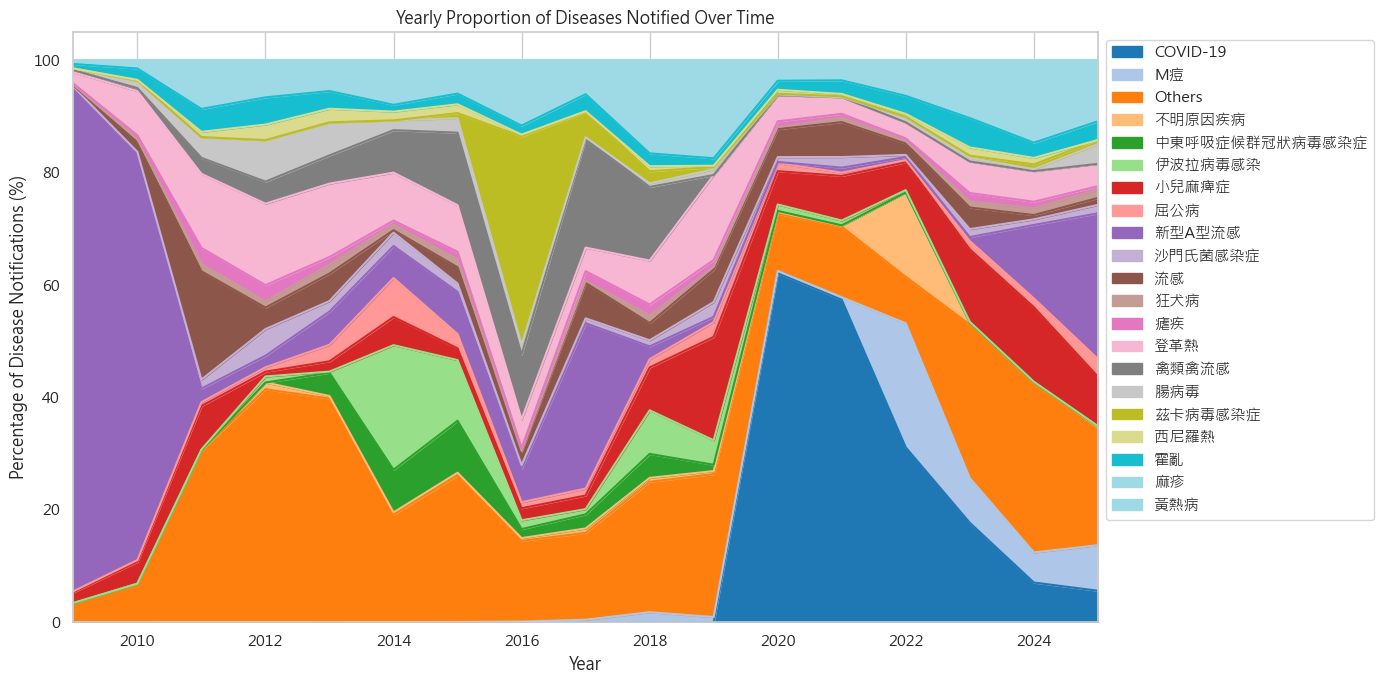

In [248]:
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['font.family'] = 'Microsoft JhengHei'

plt.rcParams['axes.unicode_minus'] = False

# üü¢ Step 1: Categorize diseases not in list_common_diseases as 'other'
df_plot = df.copy()
df_plot['disease_grouped'] = df_plot['disease_name'].apply(
    lambda x: x if x in list_common_diseases else 'Others'
)

# üü¢ Step 2: Group by month and grouped disease name
df_plot['date'] = pd.to_datetime(df_plot['date'], errors='coerce')
df_counts = (
    df_plot
    .groupby([df_plot['date'].dt.to_period('Y'), 'disease_grouped'])# Y Q M
    .size()
    .reset_index(name='count')
)

# Convert Period to Timestamp
df_counts['date'] = df_counts['date'].dt.to_timestamp()

# üü¢ Step 3: Pivot and normalize to percentage
df_pivot = df_counts.pivot(index='date', columns='disease_grouped', values='count').fillna(0)
df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

# üü¢ Step 4: Plot stacked area chart
plt.figure(figsize=(12, 6))
df_percent.plot(kind='area', stacked=True, figsize=(14, 7), colormap='tab20')
plt.ylabel('Percentage of Disease Notifications (%)')
plt.title('Yearly Proportion of Diseases Notified Over Time')
plt.xlabel('Year')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig("output/plot/disease_proportion_annual_trend.png", dpi=300)
plt.show()

### Disease Sunky bump plot

In [258]:
# sanky bump 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# üü¢ Assume your df already loaded
df_plot = df.copy()
list_common_diseases = df_plot['disease_name'].value_counts().nlargest(15).index.tolist()

# üü¢ Grouping
df_plot['disease_grouped'] = df_plot['disease_name'].apply(
    lambda x: x if x in list_common_diseases else 'Others'
)
df_plot['date'] = pd.to_datetime(df_plot['date'], errors='coerce')
df_plot['year'] = df_plot['date'].dt.year

# üü¢ Count + Percent
df_counts = (
    df_plot.groupby(['year', 'disease_grouped'])
    .size()
    .reset_index(name='count')
)

df_total = df_counts.groupby('year')['count'].sum().reset_index(name='total')
df_counts = df_counts.merge(df_total, on='year')
df_counts['percent'] = df_counts['count'] / df_counts['total'] * 100

# üü¢ Rank (lower is more frequent)
df_counts['rank'] = df_counts.groupby('year')['count'].rank(ascending=False, method='first')

# üü¢ Assign colors by default order
unique_diseases = df_counts['disease_grouped'].unique()
colors = px.colors.qualitative.Bold + px.colors.qualitative.Safe
color_map = {d: colors[i % len(colors)] for i, d in enumerate(unique_diseases)}

# üü¢ Plot
fig = go.Figure()

for disease in unique_diseases:
    df_d = df_counts[df_counts['disease_grouped'] == disease]
    fig.add_trace(go.Scatter(
        x=df_d['year'],
        y=df_d['rank'],
        mode='lines+markers',
        name=disease,
        line=dict(width=3, color=color_map[disease]),
        marker=dict(
            size=df_d['percent'],
            sizemode='area',
            sizeref=2.*max(df_counts['percent'])/(40.**2),
            sizemin=4,
            color=color_map[disease],
            line=dict(width=0.5, color='black')
        ),
        text=[
            f"{disease}<br>{year}<br>{round(p,1)}%" for disease, year, p in zip(
                df_d['disease_grouped'], df_d['year'], df_d['percent'])
        ],
        hoverinfo='text'
    ))

fig.update_yaxes(
    title='Ranking (Top = 1)',
    autorange='reversed',
    dtick=1,
    tickmode='linear'
)
fig.update_xaxes(
    title='Year',
    tickmode='linear',
    dtick=1
)

fig.update_layout(
    title=dict(
        text="Disease Notification Stream: Ranked Trends by Year",
        font=dict(size=24)
    ),
    font=dict(size=14, family='Microsoft JhengHei'),
    legend=dict(
        title='Disease',
        font=dict(size=14),
        traceorder='normal',
        bgcolor='rgba(255,255,255,0.7)'
    ),
    margin=dict(l=40, r=240, t=60, b=60),
    width=1100,
    height=700
)

fig.show()


### Top 5 disease name heatmap

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_12716\352946016.py:51: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


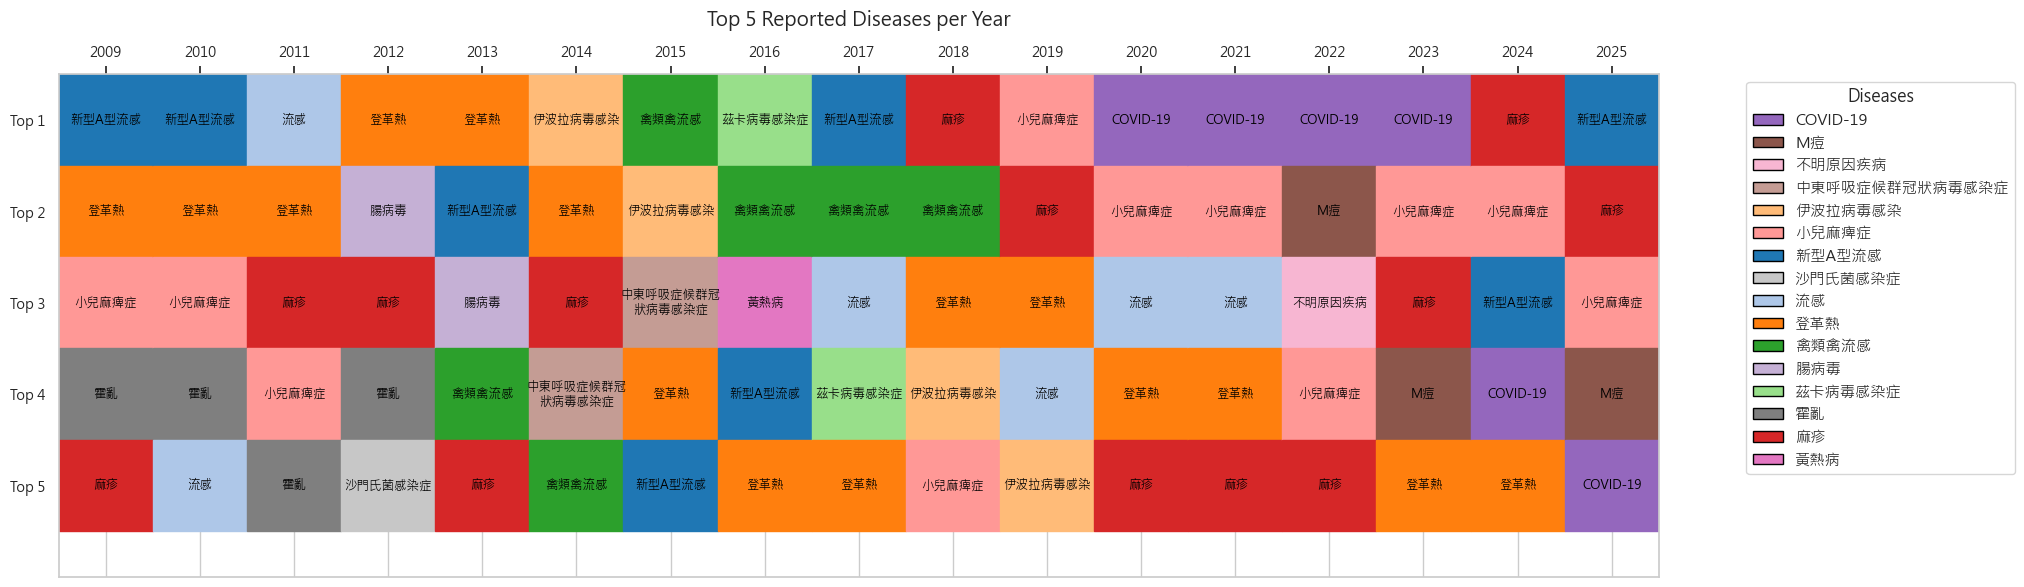

In [204]:
# Top N disease name

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import textwrap
# üü¢ Step 1‚Äì4: Same as before
df_plot = df[df['disease_name'].isin(list_common_diseases)].copy()
df_plot['date'] = pd.to_datetime(df_plot['date'], errors='coerce')
df_plot['year'] = df_plot['date'].dt.year

df_counts = (
    df_plot
    .groupby(['year', 'disease_name'])
    .size()
    .reset_index(name='count')
)

top5_per_year = (
    df_counts
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')
    .head(5)
)

ranked = (
    top5_per_year
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')['disease_name']
    .apply(list)
    .reset_index()
)
years = ranked['year'].tolist()
disease_table = pd.DataFrame([r + [None] * (5 - len(r)) for r in ranked['disease_name']], index=years).T

# üü¢ Assign unique color
all_diseases = pd.unique(disease_table.values.ravel())
color_map = dict(zip(all_diseases, plt.cm.tab20.colors[:len(all_diseases)]))

# üü¢ Step 5: Plot
fig, ax = plt.subplots(figsize=(len(years) * 1.2, 6))
ax.set_xlim(0, len(years))
ax.set_ylim(-0.5, 5)


# Draw cells
for col, year in enumerate(years):
    for row in range(5):
        disease = disease_table.iloc[row, col]
        color = color_map.get(disease, 'lightgray')
        ax.add_patch(plt.Rectangle((col, 4 - row), 1, 1, color=color, edgecolor='black'))
        wrapped = "\n".join(textwrap.wrap(disease, width=8)) if disease else ''
        ax.text(col + 0.5, 4 - row + 0.5, wrapped,
                ha='center', va='center', fontsize=9, color='black')

# üü¢ Step 6: Top X-axis for years
ax.set_xticks([i + 0.5 for i in range(len(years))])
ax.set_xticklabels([str(year) for year in years], rotation=0, fontsize=10)
ax.xaxis.set_label_position('top')  # move x-axis label to top
ax.xaxis.tick_top()

# üü¢ Step 6.5: Left Y-axis for "Top 1" to "Top 5"
ax.set_yticks([i + 0.5 for i in range(5)])
ax.set_yticklabels([f"Top {i+1}" for i in range(5)][::-1], fontsize=10)

# üü¢ Step 7: Legend
legend_elements = [
    Patch(facecolor=color_map[d], edgecolor='black', label=d)
    for d in sorted(color_map) if d is not None
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Diseases")

plt.title("Top 5 Reported Diseases per Year", fontsize=14, y=1.08)
plt.tight_layout()
plt.show()



### Report histogram

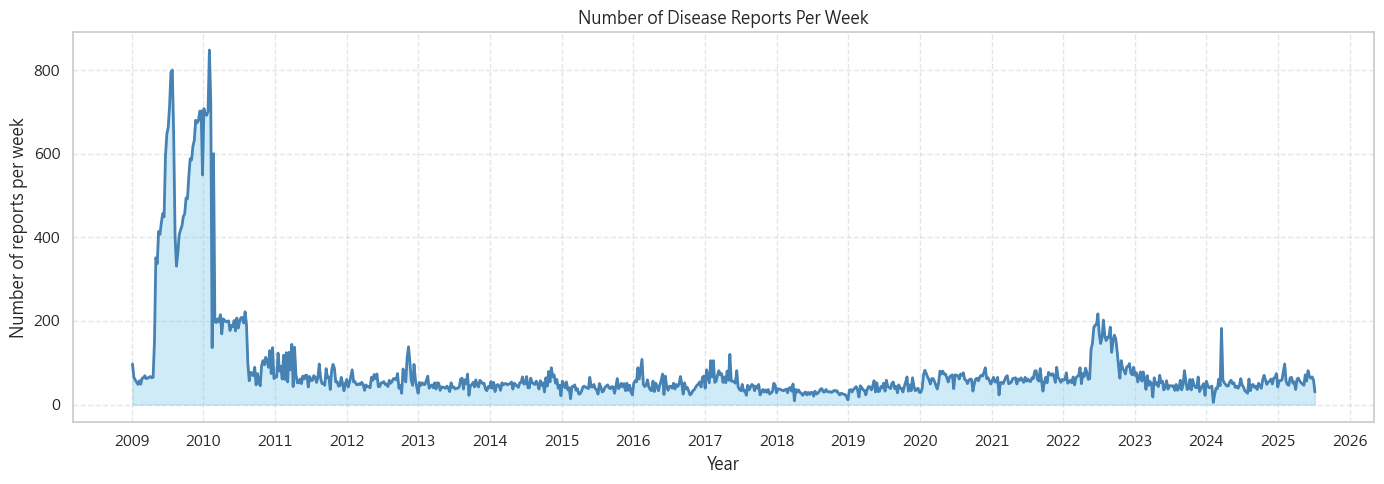

In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# üü¢ Step 1: Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# üü¢ Step 2: Create a new 'week' column that represents the start of each week
df['week'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)

# üü¢ Step 3: Group by week and count number of reports per week
df_weekly_counts = df.groupby('week').size().reset_index(name='count')

# üü¢ Step 4: Plot the weekly report count as a bar chart
plt.figure(figsize=(14, 5))
plt.plot(df_weekly_counts['week'], df_weekly_counts['count'], linestyle='-', color='steelblue', linewidth=2)
plt.fill_between(df_weekly_counts['week'], df_weekly_counts['count'], color='skyblue', alpha=0.4)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis='x', length=0)
ax.tick_params(axis='y', length=0)
ax.set_yticks([])

plt.title('Number of Disease Reports Per Week')
plt.xlabel('Year')
plt.ylabel('Number of reports per week')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Bubble plot by disease

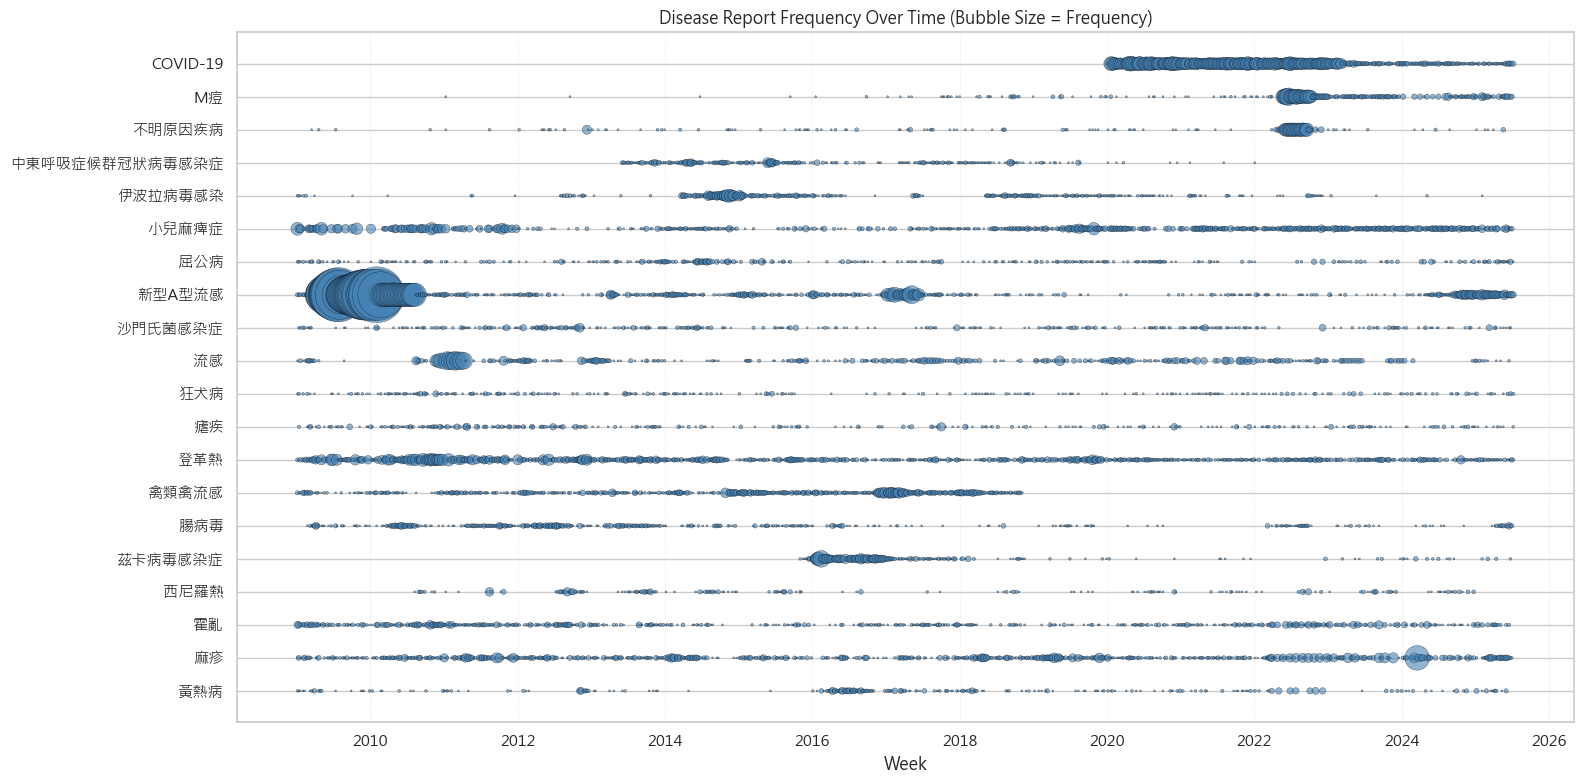

In [206]:
import pandas as pd
import matplotlib.pyplot as plt

# üü¢ Step 1: Prepare data
df_plot = df[df['disease_name'].isin(list_common_diseases)].copy()
df_plot['date'] = pd.to_datetime(df_plot['date'])
df_plot['week'] = df_plot['date'].dt.to_period('W').apply(lambda r: r.start_time)

# üü¢ Step 2: Count reports per week per disease
df_counts = (
    df_plot
    .groupby(['disease_name', 'week'])
    .size()
    .reset_index(name='count')
)

# üü¢ Step 3: Assign numeric Y positions
disease_list = sorted(df_counts['disease_name'].unique())
disease_to_y = {d: i for i, d in enumerate(disease_list)}
df_counts['y'] = df_counts['disease_name'].map(disease_to_y)

# üü¢ Step 4: Plot bubble chart
fig, ax = plt.subplots(figsize=(16, len(disease_list) * 0.4))

scatter = ax.scatter(
    df_counts['week'],             # X-axis (time)
    df_counts['y'],                # Y-axis (disease index)
    s=df_counts['count'] * 2,      # Bubble size (tune scale if needed)
    alpha=0.6,
    color='steelblue',
    edgecolors='black',
    linewidth=0.3
)

# üü¢ Step 5: Format axes
ax.set_yticks(range(len(disease_list)))
ax.set_yticklabels(disease_list)
ax.set_xlabel("Week")
ax.set_title("Disease Report Frequency Over Time (Bubble Size = Frequency)")
ax.invert_yaxis()  # Optional: most frequent disease at top
ax.grid(True, axis='x', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show() 


### Bubble plot for PHEIC diseases

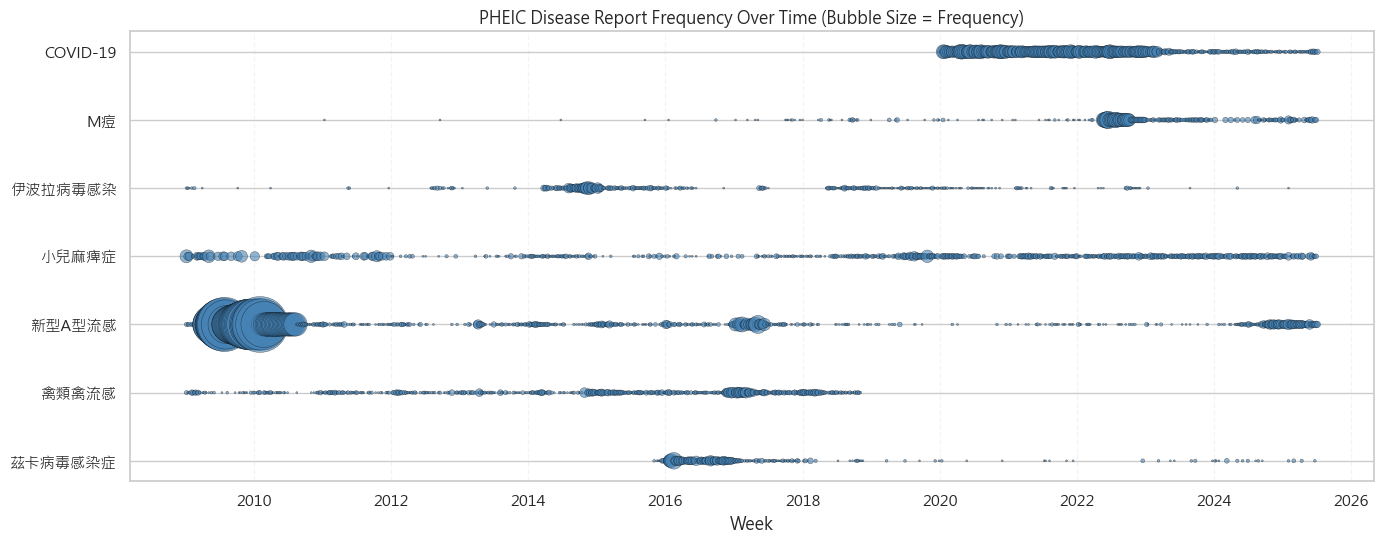

In [207]:
# only PHEIC diseases
import pandas as pd
import matplotlib.pyplot as plt


list_PHEIC_diseases = ["COVID-19","Êñ∞ÂûãAÂûãÊµÅÊÑü","Á¶ΩÈ°ûÁ¶ΩÊµÅÊÑü","Â∞èÂÖíÈ∫ªÁó∫Áóá","‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì","MÁóò","Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá"]


df_plot = df[df['disease_name'].isin(list_PHEIC_diseases)].copy()
df_plot['date'] = pd.to_datetime(df_plot['date'])
df_plot['week'] = df_plot['date'].dt.to_period('W').apply(lambda r: r.start_time)

# üü¢ Step 2: Count reports per week per disease
df_counts = (
    df_plot
    .groupby(['disease_name', 'week'])
    .size()
    .reset_index(name='count')
)

# üü¢ Step 3: Assign numeric Y positions
disease_list = sorted(df_counts['disease_name'].unique())
disease_to_y = {d: i for i, d in enumerate(disease_list)}
df_counts['y'] = df_counts['disease_name'].map(disease_to_y)

# üü¢ Step 4: Plot bubble chart
fig, ax = plt.subplots(figsize=(14, len(disease_list) * 0.8))

scatter = ax.scatter(
    df_counts['week'],             # X-axis (time)
    df_counts['y'],                # Y-axis (disease index)
    s=df_counts['count'] * 2,      # Bubble size (tune scale if needed)
    alpha=0.6,
    color='steelblue',
    edgecolors='black',
    linewidth=0.3
)

# üü¢ Step 5: Format axes
ax.set_yticks(range(len(disease_list)))
ax.set_yticklabels(disease_list)
ax.set_xlabel("Week")
ax.set_title("PHEIC Disease Report Frequency Over Time (Bubble Size = Frequency)")
ax.invert_yaxis()  # Optional: most frequent disease at top
ax.grid(True, axis='x', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()


## transmission routes


<Figure size 1200x600 with 0 Axes>

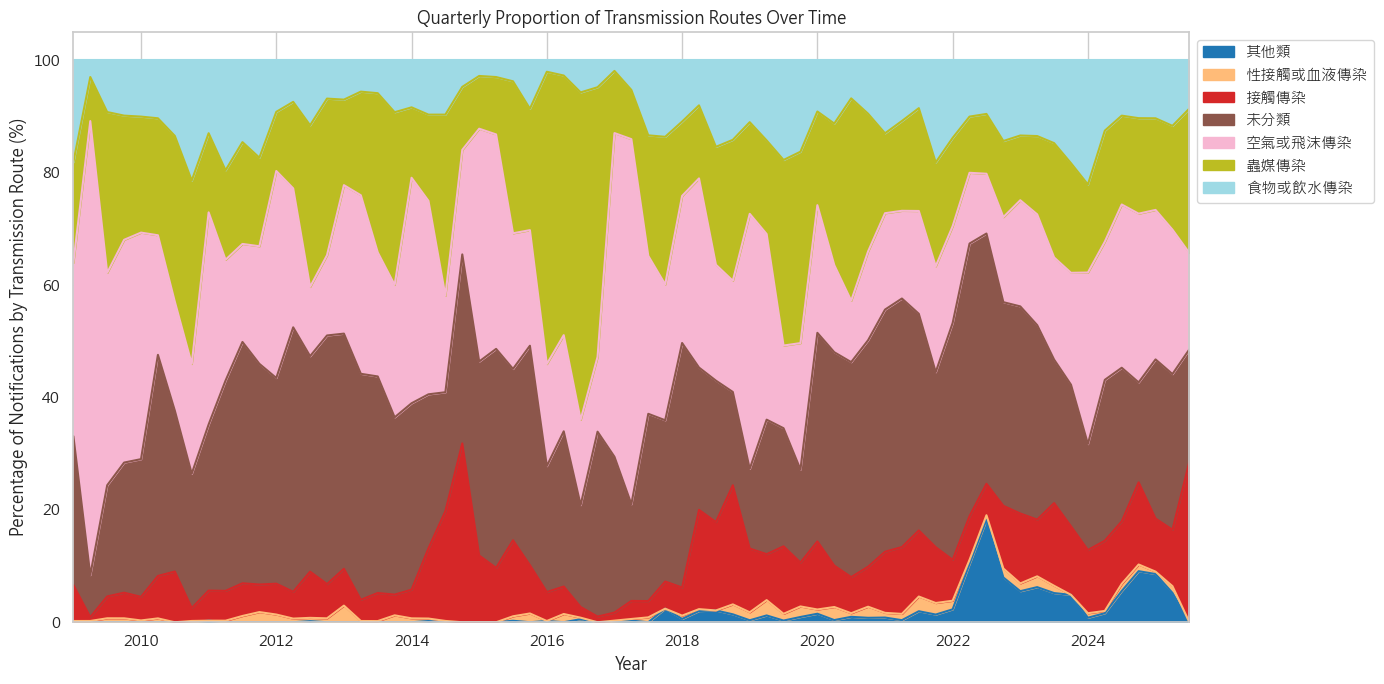

In [208]:
import matplotlib.pyplot as plt
import matplotlib

# üßæ Font settings for Traditional Chinese
plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False

# üü¢ Step 1: Prepare copy and fill NaNs
df_plot = df_raw.copy()
df_plot['transmission_route'] = df_plot['transmission_route'].fillna('Êú™ÂàÜÈ°û')

# üü¢ Step 2: Extract quarter and group counts by quarter + transmission route
df_plot['date'] = pd.to_datetime(df_plot['date'], errors='coerce')

df_counts = (
    df_plot
    .groupby([df_plot['date'].dt.to_period('Q'), 'transmission_route'])  # quarterly
    .size()
    .reset_index(name='count')
)

# üü¢ Step 3: Convert period to timestamp
df_counts['date'] = df_counts['date'].dt.to_timestamp()

# üü¢ Step 4: Pivot and normalize to percentage
df_pivot = df_counts.pivot(index='date', columns='transmission_route', values='count').fillna(0)
df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

# üü¢ Step 5: Plot stacked area chart
plt.figure(figsize=(12, 6))
df_percent.plot(kind='area', stacked=True, figsize=(14, 7), colormap='tab20')
plt.ylabel('Percentage of Notifications by Transmission Route (%)')
plt.title('Quarterly Proportion of Transmission Routes Over Time')
plt.xlabel('Year')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Country visualisations

### Top ten countries

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_12716\2206951059.py:55: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


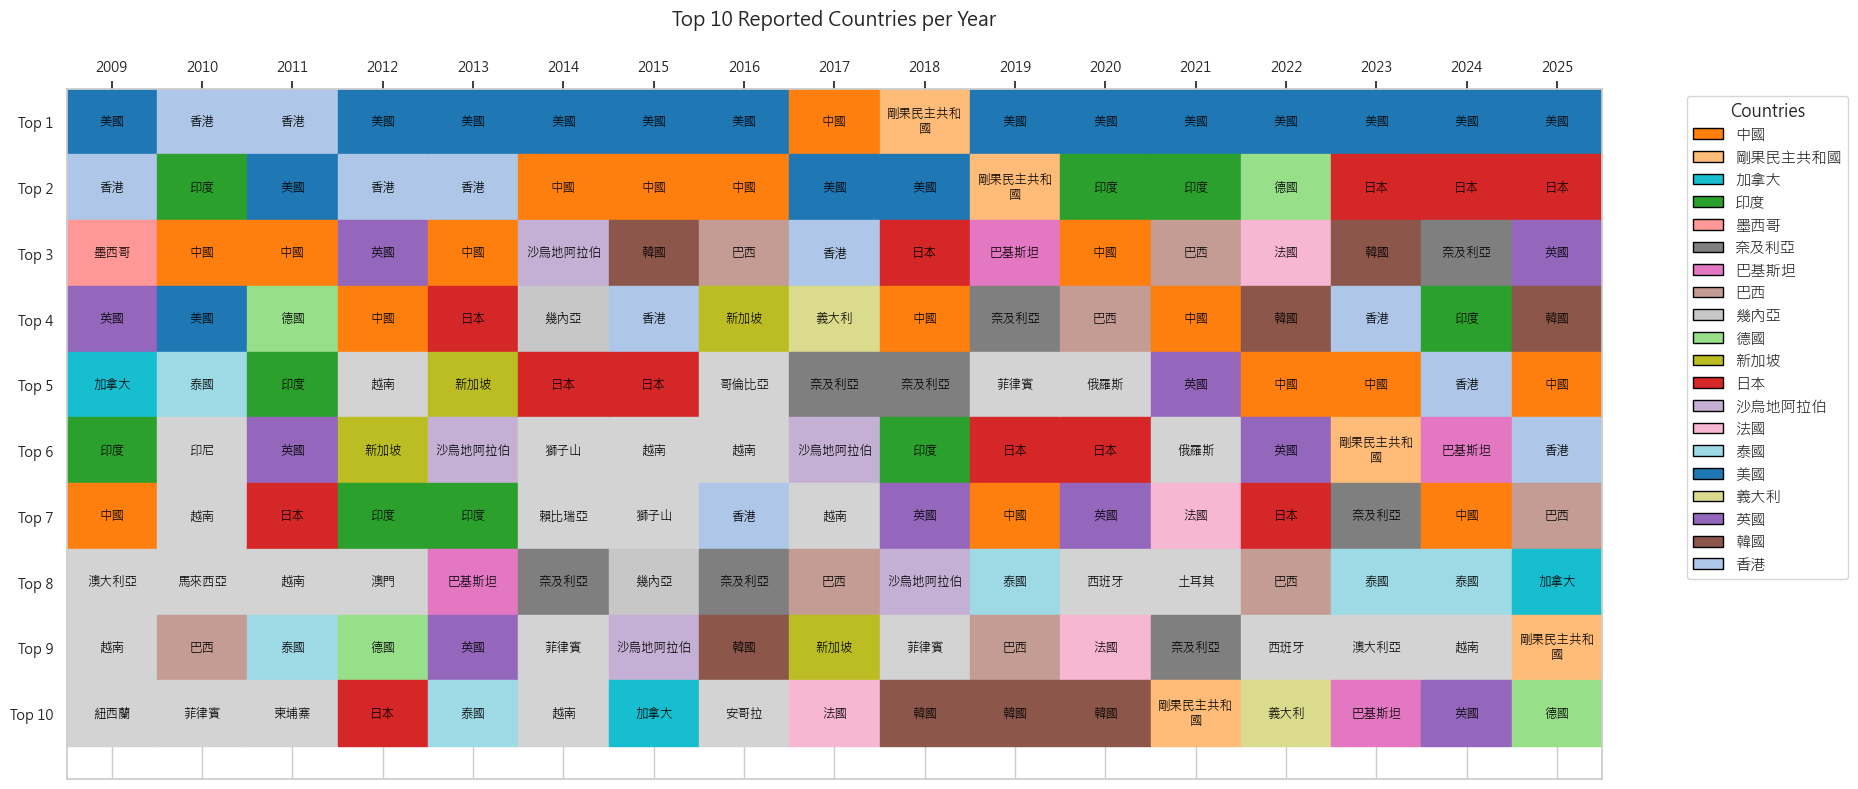

In [209]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import textwrap

n_top_countries = 10

# üü¢ Prepare data
df_plot = df.copy()
df_plot['year'] = pd.to_datetime(df_plot['date']).dt.year

df_counts = (
    df_plot
    .groupby(['year', 'country_name_zh'])
    .size()
    .reset_index(name='count')
)

top_countries_per_year = (
    df_counts
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')
    .head(n_top_countries)
)

# üü¢ Reshape for plotting
ranked = (
    top_countries_per_year
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')['country_name_zh']
    .apply(list)
    .reset_index()
)

years = ranked['year'].tolist()
country_table = pd.DataFrame(
    [r + [None] * (n_top_countries - len(r)) for r in ranked['country_name_zh']],
    index=years
).T

# üü¢ Assign unique colors
all_countries = pd.unique(country_table.values.ravel())
color_map = dict(zip(all_countries, plt.cm.tab20.colors[:len(all_countries)]))

# üü¢ Plot
fig, ax = plt.subplots(figsize=(len(years) * 1.1, 8))
ax.set_xlim(0, len(years))
ax.set_ylim(-0.5, n_top_countries)

# Draw cells
for col, year in enumerate(years):
    for row in range(n_top_countries):
        country = country_table.iloc[row, col]
        color = color_map.get(country, 'lightgray')
        ax.add_patch(plt.Rectangle((col, n_top_countries - 1 - row), 1, 1, color=color, edgecolor='black'))
        wrapped = "\n".join(textwrap.wrap(country, width=6)) if country else ''
        ax.text(col + 0.5, n_top_countries - 1 - row + 0.5, wrapped,
                ha='center', va='center', fontsize=9, color='black')

# Top X-axis for years
ax.set_xticks([i + 0.5 for i in range(len(years))])
ax.set_xticklabels([str(year) for year in years], rotation=0, fontsize=10)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Left Y-axis for rankings
ax.set_yticks([i + 0.5 for i in range(n_top_countries)])
ax.set_yticklabels([f"Top {i+1}" for i in range(n_top_countries)][::-1], fontsize=10)

# Legend
legend_elements = [
    Patch(facecolor=color_map[c], edgecolor='black', label=c)
    for c in sorted(color_map) if c is not None
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Countries")

plt.title(f"Top {n_top_countries} Reported Countries per Year", fontsize=14, y=1.08)
plt.tight_layout()
plt.show()

In [210]:
### Top regions

### Top N country_disease

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_12716\821595555.py:74: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


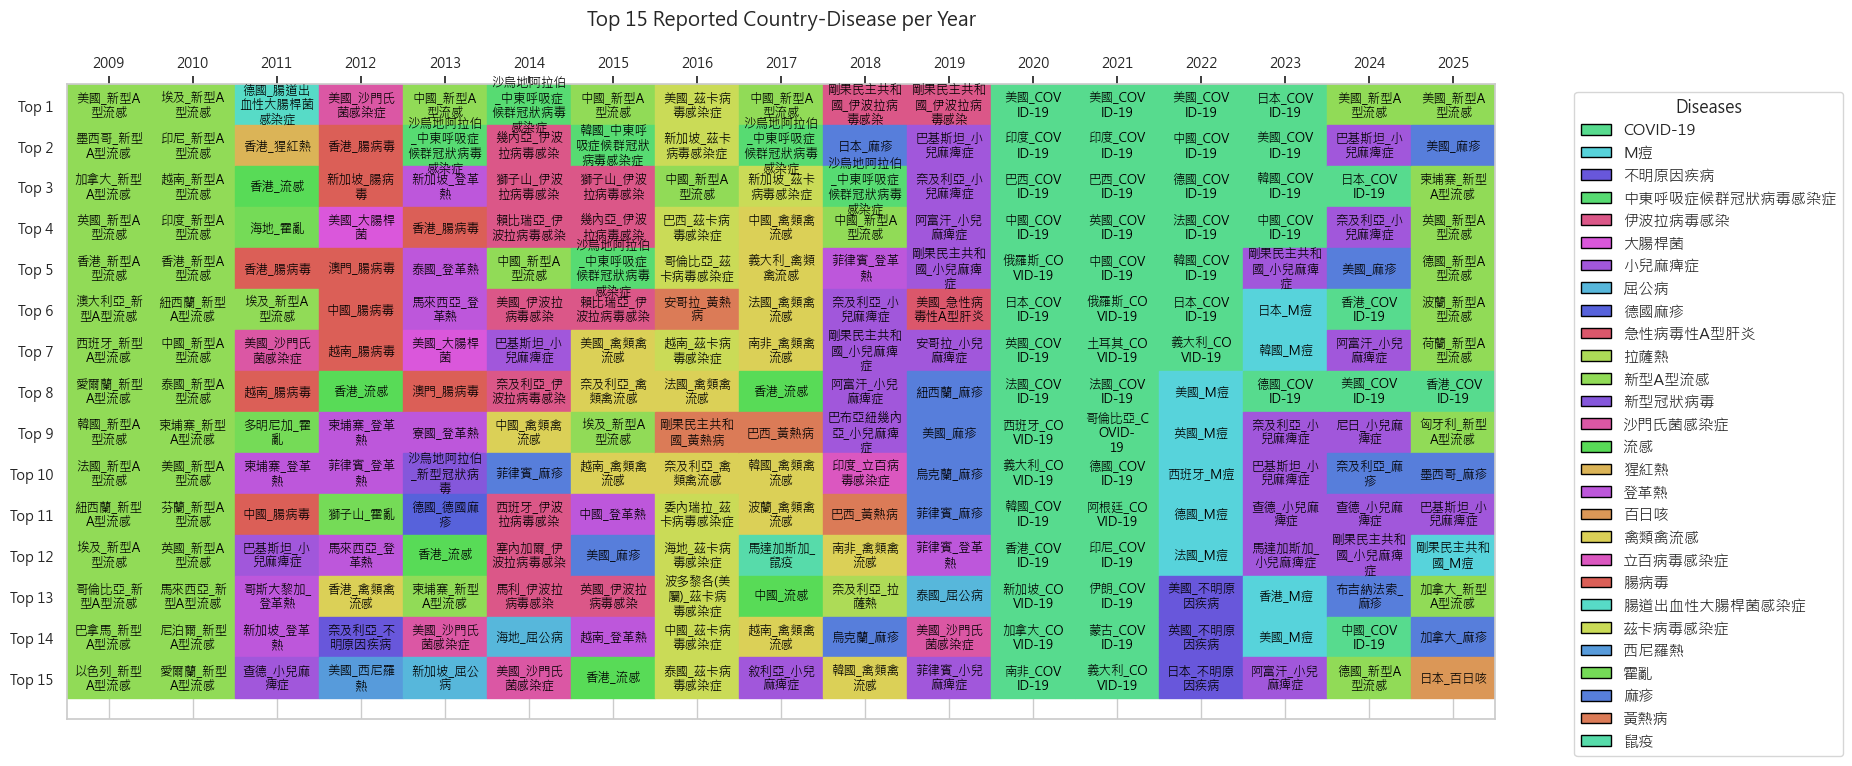

In [211]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch
import textwrap

# üü¢ Parameters
n_top_countries = 15

# üü¢ Prepare data
df_plot = df.copy()
df_plot['year'] = pd.to_datetime(df_plot['date']).dt.year

# Group by year and country_disease, count occurrences
df_counts = (
    df_plot
    .groupby(['year', 'country_disease'])
    .size()
    .reset_index(name='count')
)

# Get top N per year
top_countries_per_year = (
    df_counts
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')
    .head(n_top_countries)
)

# Reshape for plotting
ranked = (
    top_countries_per_year
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')['country_disease']
    .apply(list)
    .reset_index()
)

years = ranked['year'].tolist()
country_table = pd.DataFrame(
    [r + [None] * (n_top_countries - len(r)) for r in ranked['country_disease']],
    index=years
).T

# üü¢ Extract unique disease names from country_disease strings in top N
diseases_in_top = set()
for col in country_table.columns:
    for val in country_table[col]:
        if val:
            disease = val.split('_')[-1]
            diseases_in_top.add(disease)

# Generate color palette for these diseases
palette = sns.color_palette("hls", len(diseases_in_top))
disease_color_map = dict(zip(diseases_in_top, palette))

# üü¢ Plot
fig, ax = plt.subplots(figsize=(len(years) * 1.1, 8))
ax.set_xlim(0, len(years))
ax.set_ylim(-0.5, n_top_countries)

# Draw cells
for col, year in enumerate(years):
    for row in range(n_top_countries):
        country_disease = country_table.iloc[row, col]
        
        if country_disease:
            # Extract disease_name from country_disease (split by "_")
            disease = country_disease.split('_')[-1]
            color = disease_color_map.get(disease, 'lightgray')
        else:
            color = 'lightgray'
        
        ax.add_patch(plt.Rectangle((col, n_top_countries - 1 - row), 1, 1, color=color, edgecolor='black'))
        wrapped = "\n".join(textwrap.wrap(country_disease, width=6)) if country_disease else ''
        ax.text(col + 0.5, n_top_countries - 1 - row + 0.5, wrapped,
                ha='center', va='center', fontsize=9, color='black')

# Top X-axis for years
ax.set_xticks([i + 0.5 for i in range(len(years))])
ax.set_xticklabels([str(year) for year in years], rotation=0, fontsize=10)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Left Y-axis for rankings
ax.set_yticks([i + 0.5 for i in range(n_top_countries)])
ax.set_yticklabels([f"Top {i+1}" for i in range(n_top_countries)][::-1], fontsize=10)

# üü¢ Legend showing only disease names
legend_elements = [
    Patch(facecolor=disease_color_map[d], edgecolor='black', label=d)
    for d in sorted(diseases_in_top) if d is not None
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Diseases")

plt.title(f"Top {n_top_countries} Reported Country-Disease per Year", fontsize=14, y=1.08)
plt.tight_layout()
plt.show()


# Variety

### 1. Diversity count (baseline)

In [212]:
variety_count = df.groupby(df['date'].dt.year)['country_disease'].nunique().reset_index()
variety_count.columns = ['year', 'unique_country_disease_count']
print(variety_count)


    year  unique_country_disease_count
0   2009                           787
1   2010                          1015
2   2011                          1085
3   2012                           907
4   2013                           714
5   2014                           626
6   2015                           640
7   2016                           630
8   2017                           591
9   2018                           475
10  2019                           603
11  2020                           549
12  2021                           573
13  2022                           729
14  2023                           760
15  2024                           784
16  2025                           511


## 2. Entropy

    year  shannon_entropy
0   2009             5.34
1   2010             5.82
2   2011             6.40
3   2012             6.20
4   2013             5.84
5   2014             5.35
6   2015             5.66
7   2016             5.58
8   2017             4.75
9   2018             5.45
10  2019             5.68
11  2020             4.94
12  2021             4.99
13  2022             5.17
14  2023             5.98
15  2024             6.10
16  2025             5.73


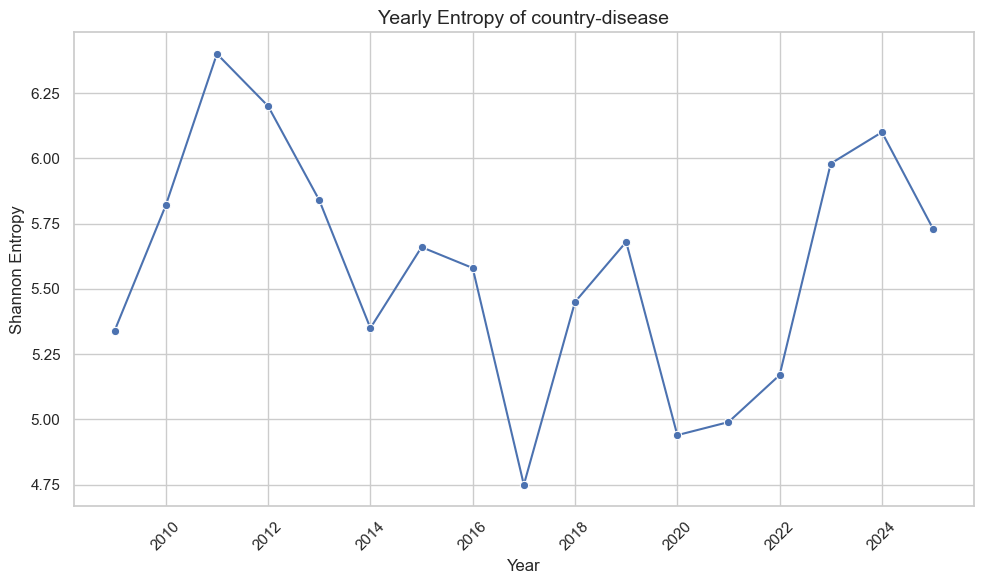

In [213]:
import numpy as np

def shannon_entropy(x):
    counts = x.value_counts()
    proportions = counts / counts.sum()
    return -np.sum(proportions * np.log(proportions))

table_entropy = df.groupby(df['date'].dt.year)['country_disease'].apply(shannon_entropy).reset_index().round(2)
table_entropy.columns = ['year', 'shannon_entropy']
print(table_entropy)


import matplotlib.pyplot as plt
import seaborn as sns

# Ensure your entropy dataframe is available
# entropy = ... (your existing calculation)

# Set seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10,6))
sns.lineplot(data=table_entropy, x='year', y='shannon_entropy', marker='o')

# Titles and labels
plt.title('Yearly Entropy of country-disease', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Shannon Entropy', fontsize=12)

# Optional: rotate x-axis labels if many years
plt.xticks(rotation=45)

# Tight layout for better spacing
plt.tight_layout()

# Show plot
plt.show()

# Timeliness

### Prepare dataset (not conslolidated one "df")
- use df_raw instead of df, which has been expanded by disease and country
- extract end date from description, and get a adjusted source date from SourceTime, SourceTime2, SourceTime_description.
- calculate interval between source date and publish
- calculate median value by year and assess missingness

In [214]:
# (1) extract date from source ###
def extract_source_time_source(row):
    source = row['Source']
    date_row = pd.to_datetime(row['date'], errors='coerce')
    year = date_row.year if pd.notna(date_row) else None

    if pd.isna(source) or year is None:
        return pd.NaT

    # Regex to find dates like "9/20" or "8/2"
    matches = re.findall(r'(\d{1,2})/(\d{1,2})', source)
    
    most_recent_date = pd.NaT

    for month_str, day_str in matches:
        month = int(month_str)
        day = int(day_str)
        try:
            date_obj = pd.Timestamp(year=year, month=month, day=day)
            
            # Skip if date_obj is after the reference date
            if date_obj > date_row:
                continue

            # Update if more recent
            if pd.isna(most_recent_date) or date_obj > most_recent_date:
                most_recent_date = date_obj

        except ValueError:
            continue  # Skip invalid dates

    return most_recent_date


df_raw['SourceTime_source'] = df_raw.apply(extract_source_time_source, axis=1)


# (2) extract the source date from the description ### 
def extract_source_time(row):
    # Only extract if both SourceTime and SourceTime2 are missing
    if pd.notna(row['SourceTime']) or pd.notna(row['SourceTime2']):
        return pd.NaT

    description = row['description']
    date_row = pd.to_datetime(row['date'], errors='coerce')
    year = pd.to_datetime(row['date'], errors='coerce').year

    if pd.isna(description):
        return pd.NaT

    # Find all patterns like "Êà™Ëá≥‰ªäÂπ¥12/8" or "Êà™Ëá≥12/8" or "‰ªäÂπ¥Êà™Ëá≥12/8" or "Êà™Ëá≥6Êúà25Êó•" or "Êà™Ëá≥‰ªäÂπ¥6Êúà25Êó•"
    matches = re.findall(r'Êà™Ëá≥(?:‰ªäÂπ¥)?(\d{1,2})[Êúà/](\d{1,2})Êó•?', description)
    
    if matches:
        dates = []
        for month_str, day_str in matches:
            month = int(month_str)
            day = int(day_str)
            try:
                date_obj = pd.Timestamp(year=year, month=month, day=day)
                dates.append(date_obj)
            except ValueError:
                continue  # skip invalid dates

        if dates:
            max_date = max(dates)
            if max_date > date_row:  # If max_date is later than date_row, treat as missing
                return pd.NaT
            else:
                return max_date    
    return pd.NaT

df_raw['SourceTime_description'] = df_raw.apply(extract_source_time, axis=1)

# (3) Get adjusted source date ###
def calculate_adjusted_source_time(row):
    t1 = row['SourceTime']
    t2 = row['SourceTime2']
    t3 = row['SourceTime_description'] 
    t4 = row['SourceTime_source']
    if pd.notna(t1) and pd.notna(t2):
        # initially I tried to look the median of t1 t2, which looks bad in 2020-2024, so now I only choose the most recent source date
        # delta_days = (t2 - t1).days
        # half_days_ceil = int(np.ceil(delta_days / 2)) #round up to an integer number of days (ÁÑ°Ê¢ù‰ª∂ÈÄ≤‰Ωç)
        # return t1 + pd.Timedelta(days=half_days_ceil)
        return t2
    elif pd.notna(t2):
        return t2
    elif pd.notna(t1):
        return t1
    elif pd.notna(t3):
        return t3
    elif pd.notna(t4):
        return t4
    else:
        return pd.NaT # Both missing

df_raw['SourceTime_adj'] = df_raw.apply(calculate_adjusted_source_time, axis=1)

# (4) calculate interval between publish date and median source date ###
def calculate_interval_source_publish(row):
    date_source = pd.to_datetime(row['SourceTime_adj'], errors='coerce')
    date_publish = pd.to_datetime(row['date'], errors='coerce')
    if pd.notna(date_source) and pd.notna(date_publish):
        delta_days = (date_publish - date_source).days
        return delta_days
    else:
        return pd.NaT 

df_raw['interval_source_publish'] = df_raw.apply(calculate_interval_source_publish, axis=1)
df_raw['year'] = pd.to_datetime(df_raw['date']).dt.year

# (5) Group by year and aggregate ###
table_timeliness_byyear = (
    df_raw.groupby('year')
    .agg(
        median_interval=('interval_source_publish', 'median'),
        mean_interval=('interval_source_publish', 'mean'),
        missing_percent=('SourceTime_adj', lambda x: x.isna().mean().round(3) * 100) )# equals to "interval_source_publish"
    .reset_index())

print(table_timeliness_byyear)

# df_raw_source_date_missing = df_raw[df_raw['interval_source_publish'].isna()]
# df_raw_source_date_missing.to_csv('interval_source_publish_missing.csv', index=True)

    year median_interval mean_interval  missing_percent
0   2009             1.0          3.53             10.6
1   2010             1.0      2.269499              3.6
2   2011             1.0      2.234707              2.8
3   2012             2.0      3.028528              1.0
4   2013             3.0      3.611853              1.0
5   2014             3.0      3.255881              0.9
6   2015             2.0      2.454362              0.3
7   2016             2.0      2.887037              0.1
8   2017             3.0     23.609732              0.1
9   2018             3.0      3.836379              0.4
10  2019             3.0      3.574383              0.6
11  2020             2.0      2.524469              0.3
12  2021             2.0      2.057014              0.1
13  2022             2.0      4.063111              1.2
14  2023             6.0      7.273143              3.0
15  2024             7.0      9.344645              4.2
16  2025             4.0      6.163743          

### Plot the median of interval source-publish

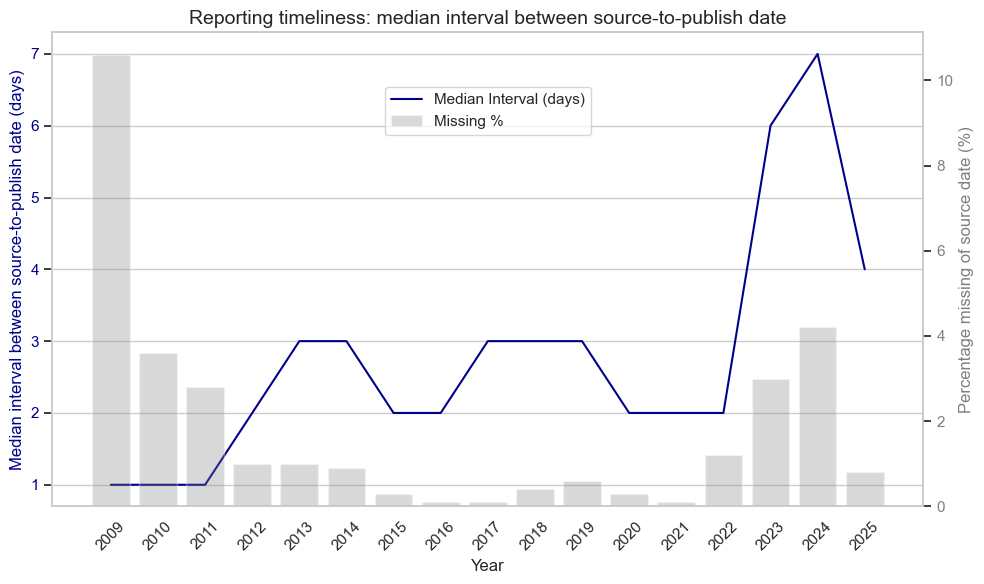

In [215]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))

# Plot median interval (line) on left y-axis
ax1.plot(table_timeliness_byyear['year'], table_timeliness_byyear['median_interval'],
         color='darkblue', label='Median Interval (days)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Median interval between source-to-publish date (days)', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')

# Set x-axis to integer years
ax1.set_xticks(table_timeliness_byyear['year'])
ax1.set_xticklabels(table_timeliness_byyear['year'].astype(int), rotation=45)
ax1.grid(axis='x', visible=False)
ax1.grid(axis='y', visible=True)

# Create right y-axis for missing percentage
ax2 = ax1.twinx()
ax2.bar(table_timeliness_byyear['year'], table_timeliness_byyear['missing_percent'],
        alpha=0.3, color='grey', label='Missing %')
ax2.set_ylabel('Percentage missing of source date (%)', color='grey')
ax2.tick_params(axis='y', labelcolor='grey')
ax2.grid(axis='y', visible=False)

# üîß Titles and layout
plt.title('Reporting timeliness: median interval between source-to-publish date', fontsize=14)
fig.tight_layout()

# üîß Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, 0.9))

plt.show()

# Sanky plot: data sources, country, disease, transmission routs

In [216]:
import pandas as pd
import plotly.graph_objects as go
import plotly.colors as pc

# Step 1: Prepare data
df['date'] = pd.to_datetime(df['date'])

df_temp = df[df['date'].dt.year > 2020]# subsetting 2009, 2020

df_temp = df_temp[['country_name_zh', 'disease_name']]


# Step 2: Keep top 5 countries and diseases, group others
top_countries = df_temp['country_name_zh'].value_counts().nlargest(10).index
top_diseases = df_temp['disease_name'].value_counts().nlargest(10).index
print(top_countries)
df_temp['country_name_zh_sanky'] = df_temp['country_name_zh'].where(df_temp['country_name_zh'].isin(top_countries), 'ÂÖ∂‰ªñÂúãÂÆ∂')
df_temp['disease_name_sanky'] = df_temp['disease_name'].where(df_temp['disease_name'].isin(top_diseases), 'ÂÖ∂‰ªñÁñæÁóÖ')

# Step 3: Group and filter
df_grouped = df_temp.groupby(['country_name_zh_sanky', 'disease_name_sanky']).size().reset_index(name='count')
df_grouped = df_grouped[df_grouped['count'] >= 100]# to make the graph less busy

# Step 4: Build node list and index
all_nodes = pd.Series(df_grouped['country_name_zh_sanky'].tolist() + df_grouped['disease_name_sanky'].tolist()).unique()
node_indices = {name: i for i, name in enumerate(all_nodes)}
df_grouped['source'] = df_grouped['country_name_zh_sanky'].map(node_indices)
df_grouped['target'] = df_grouped['disease_name_sanky'].map(node_indices)

# Step 5: Assign reasonable node colors
# Use pastel Set3 for visual harmony (enough contrast, easy on eyes)
# color_palette = pc.qualitative.Set3
# node_colors = [color_palette[i % len(color_palette)] for i in range(len(all_nodes))]
color_palette = pc.qualitative.Bold  # High-contrast, vivid
node_colors = [color_palette[i % len(color_palette)] for i in range(len(all_nodes))]


# Step 6: Assign link colors based on target (disease node)
target_colors = {name: node_colors[node_indices[name]] for name in df_grouped['disease_name_sanky'].unique()}
df_grouped['link_color'] = df_grouped['disease_name_sanky'].map(target_colors)

# Step 7: Build Sankey diagram
fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,
        color=node_colors
    ),
    link=dict(
        source=df_grouped['source'],
        target=df_grouped['target'],
        value=df_grouped['count'],
        color=df_grouped['link_color']  # match disease color
    )
)])

fig.update_layout(
    width=800,
    height=900,
    title_text="Sankey Diagram: Countries to Diseases, 2020-2025",
    font_size=12
)
fig.show()




Index(['ÁæéÂúã', '‰∏≠Âúã', 'Êó•Êú¨', 'Â∑¥Ë•ø', 'Ëã±Âúã', 'ÈüìÂúã', 'Âæ∑Âúã', 'Ê≥ïÂúã', 'Âç∞Â∫¶', 'Â•àÂèäÂà©‰∫û'], dtype='object', name='country_name_zh')


### Sanky: country-disease-route

In [243]:
import pandas as pd
import plotly.graph_objects as go
import plotly.colors as pc

# === Step 1: Prepare and clean data ===
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df_temp = df[df['date'].dt.year > 2020][['WHO_region', 'country_name_zh', 'disease_name', 'transmission_route']]

# === Step 2: Keep top N countries and diseases for clarity ===
top_countries = df_temp['country_name_zh'].value_counts().nlargest(15).index
top_diseases = df_temp['disease_name'].value_counts().nlargest(15).index

df_temp['country_grouped'] = df_temp['country_name_zh'].where(df_temp['country_name_zh'].isin(top_countries), 'ÂÖ∂ÂÆÉÂúãÂÆ∂')
df_temp['disease_grouped'] = df_temp['disease_name'].where(df_temp['disease_name'].isin(top_diseases), 'ÂÖ∂ÂÆÉÁñæÁóÖ')
df_temp['route_grouped'] = df_temp['transmission_route'].fillna('Unknown')
df_temp['region_grouped'] = df_temp['WHO_region'].fillna('Other')

# === Step 3: Create three sets of links ===
link0 = (
    df_temp.groupby(['region_grouped', 'country_grouped'])
    .size()
    .reset_index(name='count')
)

link1 = (
    df_temp.groupby(['country_grouped', 'disease_grouped'])
    .size()
    .reset_index(name='count')
)

link2 = (
    df_temp.groupby(['disease_grouped', 'route_grouped'])
    .size()
    .reset_index(name='count')
)

# === Step 4: Filter small links to reduce clutter ===
link0 = link0[link0['count'] >= 50]
link1 = link1[link1['count'] >= 50]
link2 = link2[link2['count'] >= 50]

# === Step 5: Build unique node list and index mapping ===
all_nodes = pd.Series(
    link0['region_grouped'].tolist() +
    link0['country_grouped'].tolist() +
    link1['disease_grouped'].tolist() +
    link2['route_grouped'].tolist()
).unique()

node_indices = {name: i for i, name in enumerate(all_nodes)}

# Map source and target indices
link0['source'] = link0['region_grouped'].map(node_indices)
link0['target'] = link0['country_grouped'].map(node_indices)

link1['source'] = link1['country_grouped'].map(node_indices)
link1['target'] = link1['disease_grouped'].map(node_indices)

link2['source'] = link2['disease_grouped'].map(node_indices)
link2['target'] = link2['route_grouped'].map(node_indices)

# === Step 6: Assign colors to nodes ===
color_palette = pc.qualitative.Bold
node_colors = [color_palette[i % len(color_palette)] for i in range(len(all_nodes))]

# Color by disease and route for links
disease_color_map = {name: node_colors[node_indices[name]] for name in link1['disease_grouped'].unique()}
route_color_map = {name: node_colors[node_indices[name]] for name in link2['route_grouped'].unique()}

link0['color'] = link0['country_grouped'].map(lambda x: node_colors[node_indices.get(x, 0)])
link1['color'] = link1['disease_grouped'].map(disease_color_map)
link2['color'] = link2['route_grouped'].map(route_color_map)

# === Step 7: Combine all links ===
df_links = pd.concat([
    link0[['source', 'target', 'count', 'color']],
    link1[['source', 'target', 'count', 'color']],
    link2[['source', 'target', 'count', 'color']]
], ignore_index=True)

# === Step 8: Plot Sankey Diagram ===
fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,
        color=node_colors
    ),
    link=dict(
        source=df_links['source'],
        target=df_links['target'],
        value=df_links['count'],
        color=df_links['color']
    )
)])


fig.update_layout(
    font=dict(size=14, color='black', family="Arial"),
    title_text="Sankey Diagram: WHO Region ‚Üí Country ‚Üí Disease ‚Üí Transmission Route (2020‚Äì2025)",
    width=1100,
    height=950
)

#fig.write_image("output/plot/Sankey_region_country_disease_route_2020_2025.png", width=1100, height=950, scale=3)
fig.show()



# Table 1 - overview table

In [231]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.isocalendar().year
df['week_number'] = df['date'].dt.isocalendar().week

# Âπ≥ÂùáÊØèÈÄ±Ê®ôÈ°åÊï∏
weekly_headline_counts = df.groupby(['year', 'week_number'])['description'].nunique().reset_index(name='Âπ≥ÂùáÊØèÈÄ±Ê®ôÈ°åÊï∏') # assuming description is valid as headline+date
mean_weekly_headline_counts = weekly_headline_counts.groupby('year')['Âπ≥ÂùáÊØèÈÄ±Ê®ôÈ°åÊï∏'].mean().round().astype(int).reset_index()

# Âπ≥ÂùáÊØèÈÄ±ÂúãÂÆ∂ÁñæÁóÖÊï∏
weekly_country_disease_counts = df.groupby(['year', 'week_number']).size().reset_index(name='Âπ≥ÂùáÊØèÈÄ±ÂúãÂÆ∂ÁñæÁóÖÊï∏')
mean_weekly_country_disease_counts = weekly_country_disease_counts.groupby('year')['Âπ≥ÂùáÊØèÈÄ±ÂúãÂÆ∂ÁñæÁóÖÊï∏'].mean().round(0).astype(int).reset_index()

# Áï∂Âπ¥ÂúãÂÆ∂Á∏ΩÊï∏(ÈùûÈáçË§á)
annual_country_counts = df.groupby(['year'])['country_name_en'].nunique().reset_index(name = 'Âπ¥Â∫¶ÂúãÂÆ∂Á∏ΩÊï∏(ÈùûÈáçË§á)')# iso3 can be missing?

# Áï∂Âπ¥ÁñæÁóÖÁ∏ΩÊï∏(ÈùûÈáçË§á)
annual_disease_counts = df.groupby(['year'])['disease_name'].nunique().reset_index(name = 'Âπ¥Â∫¶ÁñæÁóÖÁ∏ΩÊï∏(ÈùûÈáçË§á)')

# Áï∂Âπ¥ÂúãÂÆ∂ÁñæÁóÖÁ∏ΩÊï∏(ÈùûÈáçË§á)
annual_country_disease_counts = df.groupby(['year'])['country_disease'].nunique().reset_index(name = 'Âπ¥Â∫¶ÂúãÂÆ∂ÁñæÁóÖÁ∏ΩÊï∏(ÈùûÈáçË§á)')

# ÊôÇÊïàÊÄß
table_timeliness_byyear_median = table_timeliness_byyear[["year","median_interval"]].round().astype(int).rename(
    columns={"median_interval": "‰∏≠‰ΩçÊï∏ÊôÇÊïàÊÄß"} )

# ÂÖßÂÆπÂ≠óÊï∏
df_raw['description_lengths'] = df_raw['description'].str.len()
word_counts_by_year = df_raw.groupby('year')['description_lengths'].mean().round().astype(int).reset_index(name = 'Âπ≥ÂùáÂ†±Â∞éÂ≠óÊï∏')


# entropy
table_entropy = table_entropy.round(1).rename(columns={'shannon_entropy': 'ÂúãÂÆ∂ÁñæÁóÖÁÜµÂÄº'})

# Áï∂Âπ¥Ë≥áÊñô‰æÜÊ∫êÊï∏Èáè(ÈùûÈáçË§á)
temp_source_exploded = df_raw.explode('Source_list')# explode the list
unique_sources_count_by_year = (
    temp_source_exploded.groupby('year')['Source_list']
    .nunique()
    .reset_index()
    .rename(columns={'Source_list': 'Ë≥áÊñô‰æÜÊ∫êÊï∏(‰∏çÈáçË§á)'}) )



# ÂÇ≥ÊüìÈÄîÂæë 
table_transmission_counts = df.groupby(['year', 'transmission_route']).size().reset_index(name='count')
table_transmission_counts['percentage'] = (
    table_transmission_counts['count'] / table_transmission_counts.groupby('year')['count'].transform('sum') * 100
)

route_ordered_columns = ['Á©∫Ê∞£ÊàñÈ£õÊ≤´ÂÇ≥Êüì', 'Êé•Ëß∏ÂÇ≥Êüì','È£üÁâ©ÊàñÈ£≤Ê∞¥ÂÇ≥Êüì','Ëü≤Â™íÂÇ≥Êüì','ÊÄßÊé•Ëß∏ÊàñË°ÄÊ∂≤ÂÇ≥Êüì','ÂÖ∂‰ªñ']
pivot_table_transmission_route = table_transmission_counts.pivot_table(
    index='year', 
    columns='transmission_route',
    values='percentage',
    fill_value=0)

ordered_columns = [col for col in route_ordered_columns if col in pivot_table_transmission_route.columns]
pivot_table_transmission_route = pivot_table_transmission_route[ordered_columns]

pivot_table_transmission_route['proportion_transmission_route'] = pivot_table_transmission_route[ordered_columns].apply(
    lambda row: ', '.join(str(int(round(val))) for val in row),
    axis=1
)

pivot_table_transmission_route = pivot_table_transmission_route.reset_index()[['year', 'proportion_transmission_route']].rename(columns={'proportion_transmission_route': 'ÊÑüÊüì‰æÜÊ∫êÁôæÂàÜÊØî'})
#print(pivot_table_transmission_route)




# merging master table 
summary_table_1 = pd.merge(mean_weekly_headline_counts, mean_weekly_country_disease_counts,
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, annual_country_counts, 
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, annual_disease_counts, 
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, annual_country_disease_counts, 
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, table_timeliness_byyear_median, #from Timeliness section
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, table_entropy,
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, word_counts_by_year,
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, unique_sources_count_by_year,
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, pivot_table_transmission_route,
                           on='year', how='outer')
# Display the result
print(summary_table_1)

    year  Âπ≥ÂùáÊØèÈÄ±Ê®ôÈ°åÊï∏  Âπ≥ÂùáÊØèÈÄ±ÂúãÂÆ∂ÁñæÁóÖÊï∏  Âπ¥Â∫¶ÂúãÂÆ∂Á∏ΩÊï∏(ÈùûÈáçË§á)  Âπ¥Â∫¶ÁñæÁóÖÁ∏ΩÊï∏(ÈùûÈáçË§á)  Âπ¥Â∫¶ÂúãÂÆ∂ÁñæÁóÖÁ∏ΩÊï∏(ÈùûÈáçË§á)  ‰∏≠‰ΩçÊï∏ÊôÇÊïàÊÄß  \
0   2009       37        392          205           85            787       1   
1   2010       31        221          203          110           1015       1   
2   2011       30         70          194          127           1085       1   
3   2012       36         58          179          130            907       2   
4   2013       35         46          136          135            710       3   
5   2014       32         51          152          119            625       3   
6   2015       28         40          146          111            640       2   
7   2016       31         48          174           86            630       2   
8   2017       28         51          153           97            591       3   
9   2018       23         30          137           79            475       3   
10  201

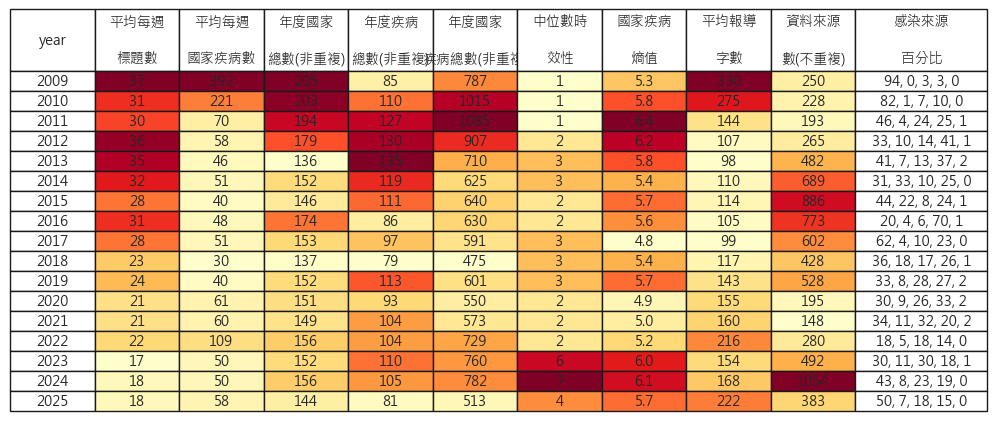

In [ ]:
# heat map table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
matplotlib.rcParams['font.family'] = 'Microsoft JhengHei' # Ensuring Mandarin layouts

summary_table_1.columns = [
    col if len(col) <= 4 else col[:4] + '\n' + col[4:]
    for col in summary_table_1.columns
]


# Initialize cell colors
cell_colors = np.full((summary_table_1.shape[0], summary_table_1.shape[1]), 'white', dtype=object)

# Apply per-column normalization for numeric columns (skip 'year')
for col_idx in range(1, summary_table_1.shape[1] -1 ): # -1 remove transmission routes
    col_values = summary_table_1.iloc[:, col_idx]
    norm = plt.Normalize(col_values.min(), col_values.max())  # Normalize per column
    for row_idx in range(summary_table_1.shape[0]):
        cell_colors[row_idx, col_idx] = plt.cm.YlOrRd(norm(col_values.iloc[row_idx]))

# Create table plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')

table = ax.table(
    cellText=summary_table_1.values,
    colLabels=summary_table_1.columns,
    cellLoc='center',
    loc='center',
    cellColours=cell_colors
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# expand first row space
for (row, col), cell in table.get_celld().items():
    if row == 0:  # Ë°®È†≠ row
        cell.set_height(0.2) 


for (row, col), cell in table.get_celld().items():
    if col == 10: # column index
        cell.set_width(0.17) # column wider 

plt.savefig("output/plot/Table_1_summary_statistics.png", dpi=300)

plt.show()



# Graph 4: PHEIC summary
For each disease, mark the frist CDC-report date,  PHEIC announance date, PHEIC end date, research end date

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# (1) PHEIC timing 
table_PHEIC_timeline = pd.DataFrame({
    'PHEIC_name': [
        'H5N1ÊµÅÊÑü',
        'Â∞èÂÖíÈ∫ªÁó∫Áóá',
        '‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì(Ë•øÈùû)',
        'Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá',
        '‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì(ÂâõÊûúÊ∞ë‰∏ªÂÖ±ÂíåÂúã)',
        'COVID-19',
        'MÁóò(IIÂûã)',
        'MÁóò(IbÂûã)'],
    'disease_name': [
        'Êñ∞ÂûãAÂûãÊµÅÊÑü/Á¶ΩÈ°ûÁ¶ΩÊµÅÊÑü',
        'Â∞èÂÖíÈ∫ªÁó∫Áóá',
        '‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì',
        'Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá',
        '‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì',
        'COVID-19',
        'MÁóò',
        'MÁóò'],
    'date_PHEIC_start': [ #references
        '2009-04-25', # https://www.who.int/groups/h1n1-ihr-emergency-committee
        '2014-05-05', # https://polioeradication.org/public-health-emergency-status/
        '2014-08-08', # https://news.un.org/en/story/2014/08/474732#:~:text=Based%20on%20the%20advice%20of%20the%20Executive%20Committee%2C,a%20Public%20Health%20Emergency%20of%20International%20Concern%20%28PHEIC%29.%E2%80%9D
        '2016-02-01', # https://www.ecdc.europa.eu/en/news-events/who-ends-zika-public-health-emergency-international-concern#:~:text=The%20Director-General%20of%20World%20Health%20Organization%20%28WHO%29%2C%20on,neurological%20disorders%20and%20Zika%20virus%20on%2018%20November.
        '2019-07-17', # https://www.who.int/news/item/17-07-2019-ebola-outbreak-in-the-democratic-republic-of-the-congo-declared-a-public-health-emergency-of-international-concern
        '2020-01-30', # https://www.who.int/publications/m/item/covid-19-public-health-emergency-of-international-concern-%28pheic%29-global-research-and-innovation-forum
        '2022-07-23', # https://www.who.int/groups/monkeypox-ihr-emergency-committee#:~:text=On%2023%20July%202022%2C%20the%20WHO%20Director-General%20determined,and%20issued%20Temporary%20Recommendations%20to%20States%20Parties%20accordingly.
        '2024-08-14'],# https://www.who.int/news/item/19-08-2024-first-meeting-of-the-international-health-regulations-(2005)-emergency-committee-regarding-the-upsurge-of-mpox-2024#:~:text=The%20Director-General%20of%20the%20World%20Health%20Organization%20%28WHO%29%2C,concern%20%28PHEIC%29%20under%20the%20provisions%20of%20the%20Regulations. 
    'date_PHEIC_end': [
        '2010-08-10', # https://www.who.int/news/item/10-08-2010-director-general-statement-following-the-ninth-meeting-of-the-emergency-committee
        None,
        '2016-03-29', # https://www.who.int/news/item/29-03-2016-statement-on-the-9th-meeting-of-the-ihr-emergency-committee-regarding-the-ebola-outbreak-in-west-africa
        '2016-11-18', # https://www.ecdc.europa.eu/en/news-events/who-ends-zika-public-health-emergency-international-concern#:~:text=The%20Director-General%20of%20World%20Health%20Organization%20%28WHO%29%2C%20on,neurological%20disorders%20and%20Zika%20virus%20on%2018%20November.
        '2020-06-25', # https://www.who.int/news/item/25-06-2020-10th-ebola-outbreak-in-the-democratic-republic-of-the-congo-declared-over-vigilance-against-flare-ups-and-support-for-survivors-must-continue
        '2023-05-05', # https://www.who.int/news/item/05-05-2023-statement-on-the-fifteenth-meeting-of-the-international-health-regulations-%282005%29-emergency-committee-regarding-the-coronavirus-disease-%28covid-19%29-pandemic
        '2023-05-11', # https://www.paho.org/en/news/11-5-2023-who-declares-end-mpox-emergency-calls-sustained-efforts-long-term-management-disease#:~:text=May%2011%2C%202023-%20The%20Emergency%20Committee%20on%20monkeypox,Concern%20%28PHEIC%29%2C%20given%20the%20sustained%20decline%20in%20cases.
        None],
    'date_study_end' : [research_end_date] * 8
})

#print(table_PHEIC_timeline)

# (2) clean PHEIC subset and get the earlist reporting date
list_PHEIC_diseases = ["COVID-19","Êñ∞ÂûãAÂûãÊµÅÊÑü","Á¶ΩÈ°ûÁ¶ΩÊµÅÊÑü","Â∞èÂÖíÈ∫ªÁó∫Áóá","‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì","MÁóò","Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá"]


df_PHEIC = df[df['disease_name'].isin(list_PHEIC_diseases)].copy()
df_PHEIC = df_PHEIC[['disease_name','date',"country_name_zh","country_iso3","description"]]
df_PHEIC.loc[df_PHEIC['disease_name'].isin(['Êñ∞ÂûãAÂûãÊµÅÊÑü', 'Á¶ΩÈ°ûÁ¶ΩÊµÅÊÑü']), 'disease_name'
             ] = 'Êñ∞ÂûãAÂûãÊµÅÊÑü/Á¶ΩÈ°ûÁ¶ΩÊµÅÊÑü'

df_PHEIC['date'] = pd.to_datetime(df_plot['date'])
df_PHEIC = df_PHEIC.sort_values(by='date')
df_PHEIC_earliest = df_PHEIC.groupby('disease_name').first().reset_index().rename(columns={'date': 'date_CDC_initial_alert'})

# (3) merge earlist reporting date to timeline
table_PHEIC_timeline = pd.merge(
    table_PHEIC_timeline,
    df_PHEIC_earliest[['disease_name','date_CDC_initial_alert','description']],
    on='disease_name',
    how='left')

# !!!!! pending: for ebola and mpox, I define that after one year of PHEIC termination, we can reset for the next PHEIC alert
#table_PHEIC_timeline.loc[table_PHEIC_timeline['PHEIC_name'] == '‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì(ÂâõÊûúÊ∞ë‰∏ªÂÖ±ÂíåÂúã)', 'date_CDC_initial_alert'] = '2017-03-29' # one year post 2016-03-29
#table_PHEIC_timeline.loc[table_PHEIC_timeline['PHEIC_name'] == 'MÁóò(IbÂûã)', 'date_CDC_initial_alert'] = '2024-05-10' # one yaer post 2023-05-11



# date formatting
for col in ['date_CDC_initial_alert', 'date_PHEIC_start', 'date_PHEIC_end', 'date_study_end']:
    table_PHEIC_timeline[col] = pd.to_datetime(table_PHEIC_timeline[col])

df_PHEIC['date'] = pd.to_datetime(df_PHEIC['date'])

# (4) pivot as a flat with shared disease_name ###
table_PHEIC_timeline["event_number"] = table_PHEIC_timeline.groupby("disease_name").cumcount() + 1

# Pivot start and end dates
pivoted = table_PHEIC_timeline.pivot(
    index=["disease_name", "date_study_end", "date_CDC_initial_alert"],
    columns="event_number",
    values=["PHEIC_name","date_PHEIC_start", "date_PHEIC_end"])


pivoted.columns = [f"{col}_{num}" for col, num in pivoted.columns]
table_PHEIC_timeline = pivoted.reset_index()

print(table_PHEIC_timeline)

# table_PHEIC_timeline2.to_excel("data/testPHEIC.xlsx", index=False)

   disease_name date_study_end date_CDC_initial_alert PHEIC_name_1  \
0      COVID-19     2025-07-09             2020-01-02     COVID-19   
1            MÁóò     2025-07-09             2011-01-14      MÁóò(IIÂûã)   
2       ‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì     2025-07-09             2009-01-05  ‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì(Ë•øÈùû)   
3         Â∞èÂÖíÈ∫ªÁó∫Áóá     2025-07-09             2009-01-06        Â∞èÂÖíÈ∫ªÁó∫Áóá   
4  Êñ∞ÂûãAÂûãÊµÅÊÑü/Á¶ΩÈ°ûÁ¶ΩÊµÅÊÑü     2025-07-09             2009-01-05       H5N1ÊµÅÊÑü   
5       Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá     2025-07-09             2015-11-02      Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá   

       PHEIC_name_2 date_PHEIC_start_1 date_PHEIC_start_2 date_PHEIC_end_1  \
0               NaN         2020-01-30                NaT       2023-05-05   
1           MÁóò(IbÂûã)         2022-07-23         2024-08-14       2023-05-11   
2  ‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì(ÂâõÊûúÊ∞ë‰∏ªÂÖ±ÂíåÂúã)         2014-08-08         2019-07-17       2016-03-29   
3               NaN         2014-05-05                N

### summary table
By disease_name, instead of PHEIC_name

In [177]:
def compute_avg_obs(subset, start, end, fallback_end):
    if pd.isnull(start):
        return None
    if pd.isnull(end):
        end = fallback_end
    interval = (end - start).days
    between = subset[(subset["date"] >= start) & (subset["date"] < end)]
    weeks = max(interval / 7, 1)
    return round(len(between) / weeks, 1)

# Main metric calculator
def calculate_metrics(row):
    disease = row['disease_name']
    alert = row['date_CDC_initial_alert']
    study_end = row['date_study_end']
    s1 = row['date_PHEIC_start_1']
    e1 = row['date_PHEIC_end_1']
    s2 = row['date_PHEIC_start_2']
    e2 = row['date_PHEIC_end_2']

    subset = df_PHEIC[df_PHEIC["disease_name"] == disease]
    result = {}

    # Interval days: alert ‚Üí start_1
    result['interval_days_alert_to_start_1'] = (s1 - alert).days if pd.notnull(alert) and pd.notnull(s1) else None

    # Weekly obs: alert ‚Üí start_1
    result['avg_obs_alert_to_start_1'] = compute_avg_obs(subset, alert, s1, study_end)
    # Weekly obs: start_1 ‚Üí end_1
    result['avg_obs_start_to_end_1'] = compute_avg_obs(subset, s1, e1, study_end)

    if disease in ["MÁóò", "‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì"]:
        # Weekly obs: end_1 ‚Üí start_2
        result['avg_obs_end1_to_start2'] = compute_avg_obs(subset, e1, s2, study_end)
        # Weekly obs: start_2 ‚Üí end_2
        result['avg_obs_start2_to_end2'] = compute_avg_obs(subset, s2, e2, study_end)
        # Weekly obs: end_2 ‚Üí study_end
        result['avg_obs_end2_to_study'] = compute_avg_obs(subset, e2, study_end, study_end)
    else:
        # Weekly obs: end_1 ‚Üí study_end
        result['avg_obs_end1_to_study'] = compute_avg_obs(subset, e1, study_end, study_end)

    return pd.Series(result)

# Apply and combine
metrics_cleaned = table_PHEIC_timeline.apply(calculate_metrics, axis=1)
table_PHEIC_summary = pd.concat([table_PHEIC_timeline, metrics_cleaned], axis=1)

print(table_PHEIC_summary.head())
#table_PHEIC_summary.to_excel("data/testPHEIC.xlsx", index=False)

   disease_name date_study_end date_CDC_initial_alert PHEIC_name_1  \
0      COVID-19     2025-07-09             2020-01-02     COVID-19   
1            MÁóò     2025-07-09             2011-01-14      MÁóò(IIÂûã)   
2       ‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì     2025-07-09             2009-01-05  ‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì(Ë•øÈùû)   
3         Â∞èÂÖíÈ∫ªÁó∫Áóá     2025-07-09             2009-01-06        Â∞èÂÖíÈ∫ªÁó∫Áóá   
4  Êñ∞ÂûãAÂûãÊµÅÊÑü/Á¶ΩÈ°ûÁ¶ΩÊµÅÊÑü     2025-07-09             2009-01-05       H5N1ÊµÅÊÑü   

       PHEIC_name_2 date_PHEIC_start_1 date_PHEIC_start_2 date_PHEIC_end_1  \
0               NaN         2020-01-30                NaT       2023-05-05   
1           MÁóò(IbÂûã)         2022-07-23         2024-08-14       2023-05-11   
2  ‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì(ÂâõÊûúÊ∞ë‰∏ªÂÖ±ÂíåÂúã)         2014-08-08         2019-07-17       2016-03-29   
3               NaN         2014-05-05                NaT              NaT   
4               NaN         2009-04-25                NaT       2010-08-10 

### Time Series Visualisation
visuals in weekly

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
from pandas.api.types import CategoricalDtype
from mizani.breaks import date_breaks
from mizani.formatters import date_format
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# --- Make sure date columns are datetime ---
date_cols = [
    'date_CDC_initial_alert', 'date_PHEIC_start_1', 'date_PHEIC_end_1',
    'date_PHEIC_start_2', 'date_PHEIC_end_2', 'date_study_end']
for col in date_cols:
    table_PHEIC_summary[col] = pd.to_datetime(table_PHEIC_summary[col])
df_PHEIC['date'] = pd.to_datetime(df_PHEIC['date'])

# --- Group for plot ---


df_PHEIC['week'] = df_PHEIC['date'].dt.to_period('W').apply(lambda r: r.start_time)

df_plot_grouped = (
    df_PHEIC
    .groupby(['disease_name', 'week'])
    .size()
    .reset_index(name='count')
    .rename(columns={'week': 'date'})  # for consistency with plotting code
)


### Manual Annotations ###
annotation_config = [
    # disease_name,        x,                  y,      label_text,                          column_name
    ('MÁóò',            '2017-11-01',          50,     "PHEICÂâç",                         'avg_obs_alert_to_start_1'),
    ('MÁóò',            '2022-11-01',          70,     "MÁóò(IIÂûã)PHEIC",                'avg_obs_start_to_end_1'),
    ('MÁóò',            '2024-02-01',          50,     "MÁóò(IbÂûã)PHEICÂæå",              'avg_obs_end1_to_start2'),
    ('MÁóò',            '2024-11-01',          30,     "MÁóò(IbÂûã)PHEIC",                'avg_obs_start2_to_end2'),
    ('COVID-19',       '2020-04-01',          10,     "PHEICÂâç",                         'avg_obs_alert_to_start_1'),
    ('COVID-19',       '2021-06-01',          20,     "PHEIC",                           'avg_obs_start_to_end_1'),
    ('COVID-19',       '2024-06-01',          20,     "PHEICÂæå",                         'avg_obs_end1_to_study'),
    ('Â∞èÂÖíÈ∫ªÁó∫Áóá',     '2013-04-01',          30,     "PHEICÂâç",                         'avg_obs_alert_to_start_1'),
    ('Â∞èÂÖíÈ∫ªÁó∫Áóá',     '2017-06-01',          30,     "PHEIC",                           'avg_obs_start_to_end_1'),
    ('Êñ∞ÂûãAÂûãÊµÅÊÑü/Á¶ΩÈ°ûÁ¶ΩÊµÅÊÑü', '2009-05-01', 230,   "PHEICÂâç",                         'avg_obs_alert_to_start_1'),
    ('Êñ∞ÂûãAÂûãÊµÅÊÑü/Á¶ΩÈ°ûÁ¶ΩÊµÅÊÑü', '2010-01-01', 70,    "PHEIC",                           'avg_obs_start_to_end_1'),
    ('Êñ∞ÂûãAÂûãÊµÅÊÑü/Á¶ΩÈ°ûÁ¶ΩÊµÅÊÑü', '2018-06-01', 170,   "PHEICÂæå",                         'avg_obs_end1_to_study'),
    ('Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá', '2015-12-01',          60,     "PHEICÂâç",                         'avg_obs_alert_to_start_1'),
    ('Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá', '2016-07-01',          40,     "PHEIC",                           'avg_obs_start_to_end_1'),
    ('Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá', '2021-06-01',          40,     "PHEICÂæå",                         'avg_obs_end1_to_study'),
    ('‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì', '2012-01-01',          20,     "PHEICÂâç",                         'avg_obs_alert_to_start_1'),
    ('‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì', '2015-01-01',          35,     "‰ºäÊ≥¢Êãâ(Ë•øÈùû)PHEIC",             'avg_obs_start_to_end_1'),
    ('‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì', '2017-02-01',          20,     "‰ºäÊ≥¢Êãâ(Ë•øÈùû)PHEICÂæå",          'avg_obs_end1_to_start2'),
    ('‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì', '2020-11-01',          35,     "‰ºäÊ≥¢Êãâ(DRC)PHEIC",             'avg_obs_start2_to_end2'),
    ('‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì', '2023-01-01',          20,     "‰ºäÊ≥¢Êãâ(DRC)PHEICÂæå",          'avg_obs_end2_to_study'),
]

custom_annotations = []
for disease, x_str, y, label_prefix, col in annotation_config:
    x = pd.to_datetime(x_str)
    value = table_PHEIC_summary.loc[
        table_PHEIC_summary['disease_name'] == disease, col].values
    if len(value) > 0 and not pd.isnull(value[0]):
        text = f"{label_prefix}:\n {round(value[0], 2)}"
        custom_annotations.append({
            'disease_name': disease,
            'x': x,
            'y': y,
            'label': text,
            'color': '#000000'
        })

df_annotations = pd.DataFrame(custom_annotations)



# --- Vertical alert lines only ---
df_lines = table_PHEIC_summary[['disease_name', 'date_CDC_initial_alert']].copy()
df_lines = df_lines.rename(columns={'date_CDC_initial_alert': 'date'})
df_lines['line_type'] = 'CDC_alert'

# --- Background ribbons for PHEIC periods ---
def make_band(row):
    disease = row['disease_name']
    study_end = row['date_study_end']
    bands = []

    # PHEIC phase 1
    if pd.notnull(row['date_PHEIC_start_1']):
        end1 = row['date_PHEIC_end_1'] if pd.notnull(row['date_PHEIC_end_1']) else (
            study_end if disease == "Â∞èÂÖíÈ∫ªÁó∫Áóá" else None
        )
        if end1:
            bands.append({
                'disease_name': disease,
                'start': row['date_PHEIC_start_1'],
                'end': end1
            })

    # PHEIC phase 2 (only for MÁóò ‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì)
    if disease in ["MÁóò","‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì"] and pd.notnull(row['date_PHEIC_start_2']):
        end2 = row['date_PHEIC_end_2'] if pd.notnull(row['date_PHEIC_end_2']) else study_end
        bands.append({
            'disease_name': disease,
            'start': row['date_PHEIC_start_2'],
            'end': end2
        })

    return bands

background_bands = pd.DataFrame([
    band for _, row in table_PHEIC_summary.iterrows()
    for band in make_band(row)
])
background_bands['label_bg'] = 'PHEIC ÊúüÈñì'

# pandel order
desired_order = ['Êñ∞ÂûãAÂûãÊµÅÊÑü/Á¶ΩÈ°ûÁ¶ΩÊµÅÊÑü','Â∞èÂÖíÈ∫ªÁó∫Áóá','‰ºäÊ≥¢ÊãâÁóÖÊØíÊÑüÊüì','Ëå≤Âç°ÁóÖÊØíÊÑüÊüìÁóá','COVID-19','MÁóò']
disease_type = CategoricalDtype(categories=desired_order, ordered=True)
for df in [df_plot_grouped, df_annotations, df_lines, background_bands]:
    df['disease_name'] = df['disease_name'].astype(disease_type)



p = (
    ggplot(df_plot_grouped, aes(x='date', y='count')) +
    facet_wrap('~disease_name', scales='free', nrow=2, ncol=3) +

    # Background shaded rectangles
    geom_rect(background_bands, aes(xmin='start', xmax='end', ymin=0, ymax=float('inf'), fill = 'label_bg'), # inf to be flexible to each maximum
               alpha=0.5, inherit_aes=False) +

   # geom_point(aes(size='count'), alpha=0.5, color='#1f78b4') +
    geom_line(aes(x='date', y='count'), color="#42A8CAAF", size=0.8) +
    # geom_area(aes(x='date', y='count'), fill='#9ecae1', alpha=0.6) +
    #geom_step(aes(x='date', y='count'), direction='mid', color='#060270')+

    # Alert lines
    geom_vline(df_lines, aes(xintercept='date'), linetype='dashed', size=0.8, color='#FE9900') +

    # Annotations
    geom_text(df_annotations,
          aes(x='x', y='y', label='label'), color='#000000',
          size=11, show_legend=False) +

    scale_size_continuous(range=[2, 8]) +
    
    labs(title='PHEICÂúãÂÆ∂ÁñæÁóÖÊØèÈÄ±Â†±Â∞éÊï∏', x='', y='ÊØèÈÄ±ÂúãÂÆ∂ÁñæÁóÖÂ†±Â∞éÊï∏', subtitle= "ÊñáÂ≠óÊ®ôË®ªÁÇ∫Ë©≤ÊúüÈñìÂπ≥ÂùáÊØèÈÄ±Â†±Â∞éÊï∏") +
    scale_fill_manual(values={'PHEIC ÊúüÈñì': '#cce5ff'}, 
                      guide=guide_legend(title=''))+
    theme_bw() +
    theme(
        figure_size=(24, 8),
        axis_text_x=element_text(rotation=45, hjust=1),
        subplots_adjust={'wspace': 0.25},
        text=element_text(family="Microsoft JhengHei"),
        strip_text=element_text(size=16),
        legend_text=element_text(size=17),
        plot_title=element_text(size=20, weight='bold') 
         )
       
)

p.show()


p.save("output/plot/pheic_timeline_plot.png", width=24, height=10, dpi=300, units='in')

